# Nootebook description
In this notebook the raw data about weather and water table depth are analyzed.
The raster data are then clipped on the ROI (Region Of Interest), while water table data are subsetted for the manually selected sensors. The resulting dataser are saved

In [1]:
!python --version # used Python 3.10.12

Python 3.10.12


# Libraries

In [2]:
!pip install geemap==0.32.0
!pip install wxee==0.4.2

!pip install numpy==1.25.2
!pip install rioxarray==0.15.5
!pip install matplotlib==3.7.1
!pip install xarray==2023.7.0
!pip install netCDF4==1.6.5
!pip install pandas==2.0.3
!pip install seaborn==0.13.1
!pip install rasterio==1.3.10
!pip install imageio==2.31.6
!pip install geopandas==0.13.2
!pip install cmasher==1.8.0
!pip install adjustText==1.1.1

!pip install cftime==1.6.3
!pip install great-circle-calculator==1.3.1
!pip install matplotlib_scalebar==0.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: geemap
    Found existing installation: geemap 0.32.1
    Uninstalling geemap-0.32.1:
      Successfully uninstalled geemap-0.32.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: rioxarray
    Found existing installation: rioxarray 0.16.0
    Uninstalling rioxarray-0.16.0:
      Successfully uninstalled rioxarray-0.16.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.3/533.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import re
import sys
import numpy as np
import rioxarray
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter
import matplotlib.pyplot as plt
import xarray
from netCDF4 import num2date
import pandas as pd
import copy
import datetime
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns

import rasterio
import rasterio.warp
from rasterio.crs import CRS
from shapely.geometry import box
import geopy.distance

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import geopandas as gpd
from rasterio.plot import show
from great_circle_calculator.great_circle_calculator import *
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import box
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import adjustText as aT
import cmasher as cmr

# Drive, directories, and modules

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [5]:
## Define your directories

data_path = "/.../Datasets/" # location of datasets
# subfolder in /datasets
meteo_data_path = data_path + "Meteo_OI_ARPA/"
shapefile_path = data_path + "shapefile_raster/"
water_table_time_series_path = data_path + "water_table_ARPA_GranaMaira/"
water_table_time_series_raw_path = water_table_time_series_path + "raw/"

# results saving path
saving_result_path = "/.../Results/" # location of results folder
result_eda_wt_meteo_path = saving_result_path + "EDA_water_table_meteo/Python/"
result_eda_GM_V_catchments = result_eda_wt_meteo_path + 'GM_V_catchments/'

In [7]:
# Import modules
sys.path.append('/.../python_modules/')

from data_handle import *
from plot_functions import *

# Shapefile and DTM

In [8]:
# Shapefiles import
italy_borders = gpd.read_file(shapefile_path + "Reg01012024_g_WGS84.shp")
italy_borders = italy_borders.to_crs('epsg:4326')
piemonte_borders = gpd.read_file(shapefile_path + "Ambiti_Amministrativi-Province.shp")
piemonte_borders = piemonte_borders.to_crs('epsg:4326')
# remove the small enclaved Cuneo area inside Torino province
piemonte_borders = piemonte_borders[:-1]

# extract bound, useful for plots
piemonte_long_min, piemonte_lat_min, piemonte_long_max, piemonte_lat_max = piemonte_borders.total_bounds

# extract Province names and coord, useful for plots
provinces_names = [piemonte_borders["nome"][i] for i in range(0,len(piemonte_borders))]
provinces_long = [piemonte_borders["geometry"][i].representative_point().coords[0][0] for i in range(0,len(piemonte_borders))]
provinces_lat = [piemonte_borders["geometry"][i].representative_point().coords[0][1] for i in range(0,len(piemonte_borders))]

In [9]:
# ARPA Water Table sensors in Cuneo and Torino Provinces
arpa_wt_sensors = gpd.read_file(shapefile_path + "CN_TO_observed_d_t_c_stations.shp")
arpa_wt_sensors = arpa_wt_sensors.to_crs('epsg:4326')

In [10]:
# Catchment shapefile
catchment = gpd.read_file(shapefile_path + "BAC_01_bacialti.shp") # select GRANA-MAIRA	and VARAITA
catchment = catchment.to_crs('epsg:4326')

# Select only the Grana-Maira catchment
catchment_GM = catchment.loc[catchment.NOME == "GRANA-MAIRA"]
catchment_GM = catchment_GM.reset_index(drop = True)

In [11]:
# Subset to Grana-Maira sensors
# Retrieve water table sensors inside Grana-Maira catchment
sensor_codes_GM = subset_sensor_incatchment(id_code_name = "ID_code", sensors_ds = arpa_wt_sensors,
                                               subset_catchment = catchment_GM)

sensor_codes_GM

['00403410001',
 '00407810001',
 '00417910001',
 '00422510001',
 '00421510001',
 '00425010001']

In [12]:
# Expert request: REMOVE Cuneo(00407810001), Tarantasca (00422510001) and Busca (00403410001)

sensor_codes_GM = [sensor_codes_GM[i] for i in range(len(sensor_codes_GM)) if sensor_codes_GM[i] not in ['00407810001','00422510001','00403410001']]

# Subset the spatial dataset (geopandas)
arpa_wt_sensors_GM = arpa_wt_sensors.loc[arpa_wt_sensors.ID_code.isin(sensor_codes_GM)]
arpa_wt_sensors_GM

ID_code  C_code            Site        Munic  \
29  00417910001  GWB-S6   P13 Racconigi    Racconigi   
48  00421510001  GWB-S6   P6 Savigliano   Savigliano   
49  00425010001  GWB-S6  P5 Vottignasco  Vottignasco   

                                                  Loc       Start   End  \
29  Giardino pubblico Via B. Murialdo angolo Via S...  2009-01-01  None   
48          c/o Stadio "Ottavio Morino", V.le Gozzano  2009-01-01  None   
49                 c/o Cimitero comunale, Via Saluzzo  2009-01-01  None   

            Type Type_s  Mun_count         ID_Munic  wt_mean  \
29  Superficiale      S          3    Racconigi_S_3    4.513   
48  Superficiale      S          4   Savigliano_S_4    3.788   
49  Superficiale      S          2  Vottignasco_S_2    4.474   

                    geometry  
29  POINT (7.68794 44.77265)  
48  POINT (7.65242 44.64596)  
49  POINT (7.57503 44.57012)

**Even if 6 sensors are available Cuneo, Busca and Tarantasce have not been modelled beacuse of data availability, missing measurements, error in data, and different measurement scenario**

In [13]:
# For labels in maps
sensor_names = list(arpa_wt_sensors_GM[['Munic','ID_code']].agg(' '.join, axis=1))

In [14]:
# DTM [50m] import
dtm_piemonte = rioxarray.open_rasterio(shapefile_path + 'DTMPiemonte_filled_50m.tif')
dtm_piemonte = dtm_piemonte.rio.reproject("epsg:4326")
dtm_piemonte = dtm_piemonte.where(dtm_piemonte != -99999) # Take valid pixel

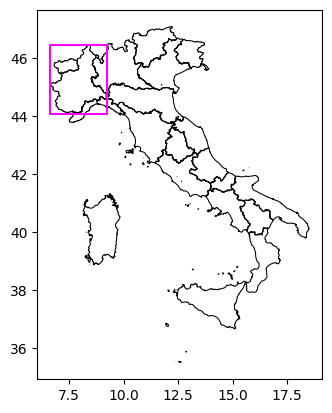

In [16]:
# Plot box Piemonte box

fig, ax = plt.subplots()
Piemonte_box = box(piemonte_long_min, piemonte_lat_min, piemonte_long_max , piemonte_lat_max)
italy_borders.boundary.plot(ax = ax, color = 'Black', linewidth = 0.75)
ax.plot(*Piemonte_box.exterior.xy, label = "Piemonte", color = "magenta")

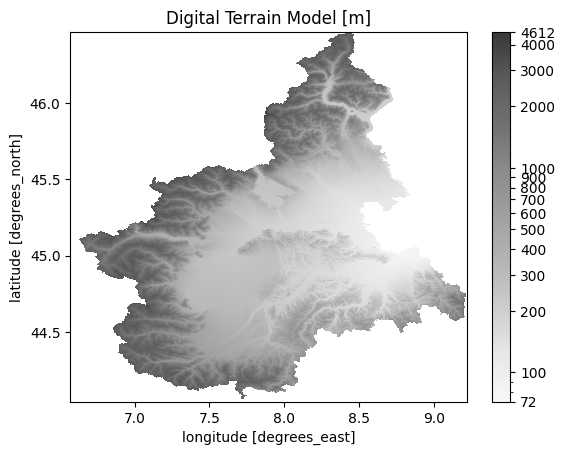

In [17]:
dtm_plot(dtm = dtm_piemonte, cmap = grayscale_cmap("Reds"),
         inner_ticks = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000],
         title = "Digital Terrain Model [m]")

plt.show()

# Meteorological dataset

Let's construct a xarray dataset. The variable inside the dataset will be precipitation, temp max, and temp min. Each variables has x (long), y (lat), and time as indices / coordinates.

In [18]:
# 24 x 20 pixels for image
tot_precipitation = xarray.open_dataset(meteo_data_path + 'NWIOIprecDAY.nc')
max_temperature = xarray.open_dataset(meteo_data_path + 'NWIOItmaxDAY.nc')
min_temperature = xarray.open_dataset(meteo_data_path + 'NWIOItminDAY.nc')
orography = xarray.open_dataset(meteo_data_path + 'arpa_orografia_netcdf.nc')
region_mask = xarray.open_dataset(meteo_data_path + 'arpa_mask_netcdf.nc')

In [19]:
tot_precipitation

<xarray.Dataset>
Dimensions:  (time: 24215, lon: 24, lat: 20)
Coordinates:
  * time     (time) datetime64[ns] 1957-12-01T12:00:00 ... 2024-03-18T12:00:00
  * lon      (lon) float64 6.563 6.688 6.813 6.938 ... 9.063 9.188 9.313 9.438
  * lat      (lat) float64 44.06 44.19 44.31 44.44 ... 46.06 46.19 46.31 46.44
Data variables:
    prec     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Mar 19 09:42:23 2024: cdo -r settaxis,1957-12-01,12:00,...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [ ]:
min_temperature

<xarray.Dataset>
Dimensions:  (time: 24215, lon: 24, lat: 20)
Coordinates:
  * time     (time) datetime64[ns] 1957-12-01T12:00:00 ... 2024-03-18T12:00:00
  * lon      (lon) float64 6.563 6.688 6.813 6.938 ... 9.063 9.188 9.313 9.438
  * lat      (lat) float64 44.06 44.19 44.31 44.44 ... 46.06 46.19 46.31 46.44
Data variables:
    tmin     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Mar 19 09:42:21 2024: cdo -r settaxis,1957-12-01,12:00,...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

<Axes: title={'center': 'time = 1957-12-01'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

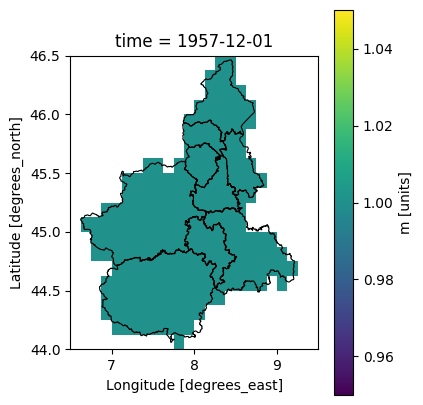

In [20]:
# Plot the region mask
fig, img_stat = plt.subplots(1,1, figsize = (4,5) )
region_mask["m"][0].plot(ax = img_stat)
piemonte_borders.boundary.plot(color = 'Black', linewidth = 0.8, ax = img_stat, alpha = 1, label="Administrative bounds")

<Axes: title={'center': 'time = 1957-12-01T12:00:00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

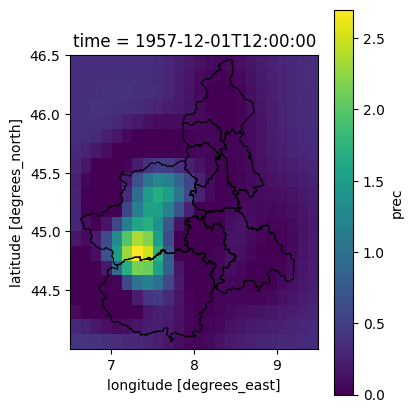

In [ ]:
# Plot a variable for a sample day
fig, img_stat = plt.subplots(1,1, figsize = (4,5) )
tot_precipitation["prec"][0].plot(ax = img_stat)
piemonte_borders.boundary.plot(color = 'Black', linewidth = 0.8, ax = img_stat, alpha = 1, label="Administrative bounds")

In [21]:
# Let's build the xarray dataset
meteorological_ds = tot_precipitation.assign({"tmax": max_temperature.tmax, "tmin": min_temperature.tmin}); meteorological_ds #xarray.Dataset(data_vars= {'tot_prec': precipitation, 'min_temp': min_temperature, 'max_temp': max_temperature})
# Drop dates before 1990 - they won't be useful
meteorological_ds =  meteorological_ds.where(meteorological_ds.time >= np.datetime64("1990-01-01"), drop = True)
# write the CRS
meteorological_ds = meteorological_ds.rio.write_crs("epsg:4326")
region_mask = region_mask.rio.write_crs("epsg:4326")
orography = orography.rio.write_crs("epsg:4326")

### EDA weather variables

In [22]:
# Compute the resolution in km
spatial_resolution_meteo =  geopy.distance.geodesic((meteorological_ds["lat"].values[0],
                               meteorological_ds["lon"].values[0]),
                               (meteorological_ds["lat"].values[1],
                                meteorological_ds["lon"].values[0])).km
print("Resolution in km: ", round(spatial_resolution_meteo, 3))

Resolution in km:  13.889


In [23]:
# Now in meters. This will be needed in the map for plotting the scale
spatial_resolution_meteo_long_1deg =  geopy.distance.geodesic((meteorological_ds["lat"].values[0],
                               meteorological_ds["lon"].values[0]),
                               (meteorological_ds["lat"].values[1],
                                meteorological_ds["lon"].values[0] + 1)).m

### Statistics

In [ ]:
meteorological_ds.max()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int64 0
Data variables:
    prec         float32 483.8
    tmax         float32 314.2
    tmin         float32 305.1

In [ ]:
meteorological_ds.min()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int64 0
Data variables:
    prec         float32 0.0
    tmax         float32 244.7
    tmin         float32 242.8

In [ ]:
meteorological_ds.mean()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int64 0
Data variables:
    prec         float32 2.849
    tmax         float32 285.7
    tmin         float32 279.7

In [ ]:
meteorological_ds.median()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int64 0
Data variables:
    prec         float32 0.181
    tmax         float32 285.3
    tmin         float32 279.6

In [ ]:
meteorological_ds.std()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int64 0
Data variables:
    prec         float32 7.683
    tmax         float32 9.281
    tmin         float32 8.055

In [ ]:
meteorological_ds.std() / meteorological_ds.mean()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int64 0
Data variables:
    prec         float32 2.696
    tmax         float32 0.03248
    tmin         float32 0.02879

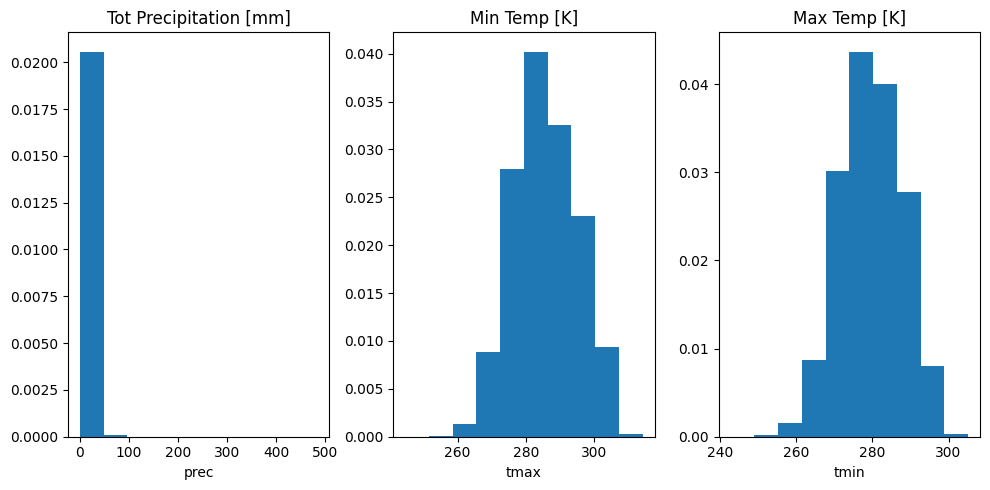

In [ ]:
# Empirical densities
sample_density_plot(meteorological_ds,
                        title_list = ["Tot Precipitation [mm]","Min Temp [K]","Max Temp [K]"],
                        saving_directory = None,
                        width = 5, height = 10)

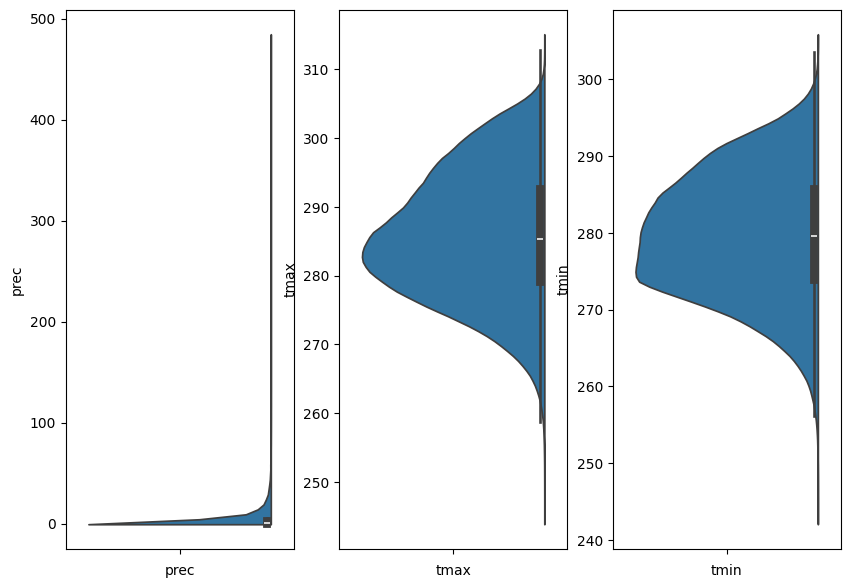

In [ ]:
# Violin plots - TIME CONSUMING (some minutes)!!!
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
all_varibles = list(meteorological_ds.keys())

for var in all_varibles:
    ds = meteorological_ds[var].drop("spatial_ref").to_dataframe()
    ds = ds.dropna()

    sns.violinplot(y = var, data = ds, density_norm = "area",
                  split=True, legend = False, ax=axes[all_varibles.index(var)]) #, width=1.5
    axes[all_varibles.index(var)].set(xlabel=var)

plt.show()
# IF YOU WANT TO SAVE:
#plt.savefig(result_eda_GM_V_catchments + "Varaita_depth_violins.png", dpi=400, bbox_inches = 'tight')
#plt.close("all")

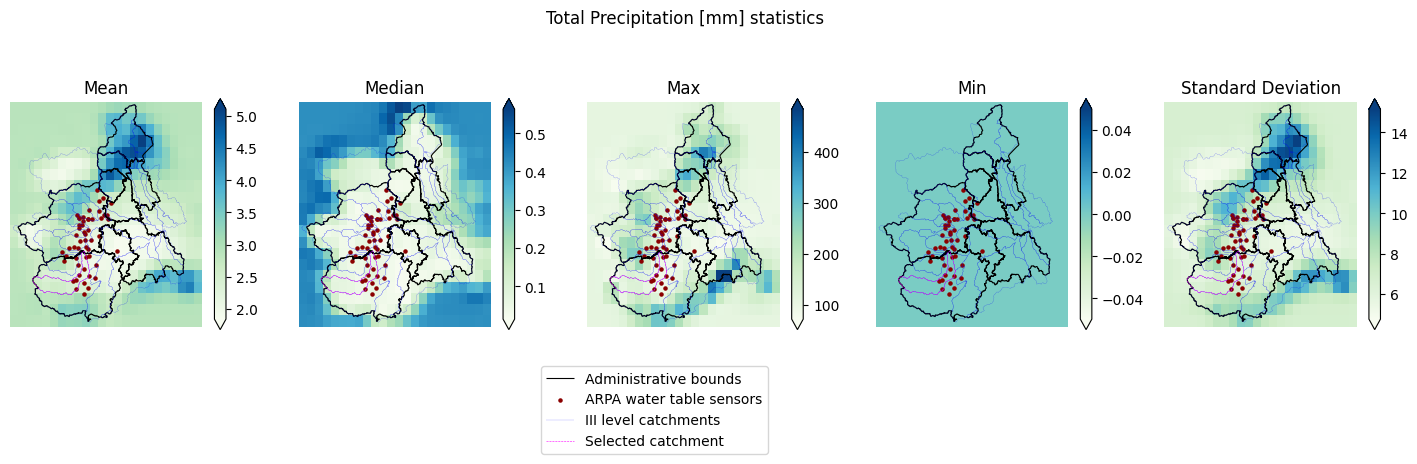

In [24]:
# Plot some spatial statistics ofr a weather variable
stat_map_plots(meteorological_raster = meteorological_ds, variable = "prec", region_shapefile = piemonte_borders,
               sensor_network_ds = arpa_wt_sensors, catchment_shapefile = catchment,
               selected_catchment = catchment_GM, cmap = "GnBu", plot_title="Total Precipitation [mm] statistics")

In [ ]:
# TO SAVE, same function with save = True and saving_path specified:
# stat_map_plots(meteorological_raster = meteorological_ds, variable = "prec", region_shapefile = piemonte_borders,
#                sensor_network_ds = arpa_wt_sensors, catchment_shapefile = catchment,
#                selected_catchment = catchment_GM_V, cmap = "GnBu",
#                plot_title="Total Precipitation [mm] statistics",
#                saving_path = result_eda_wt_meteo_path)

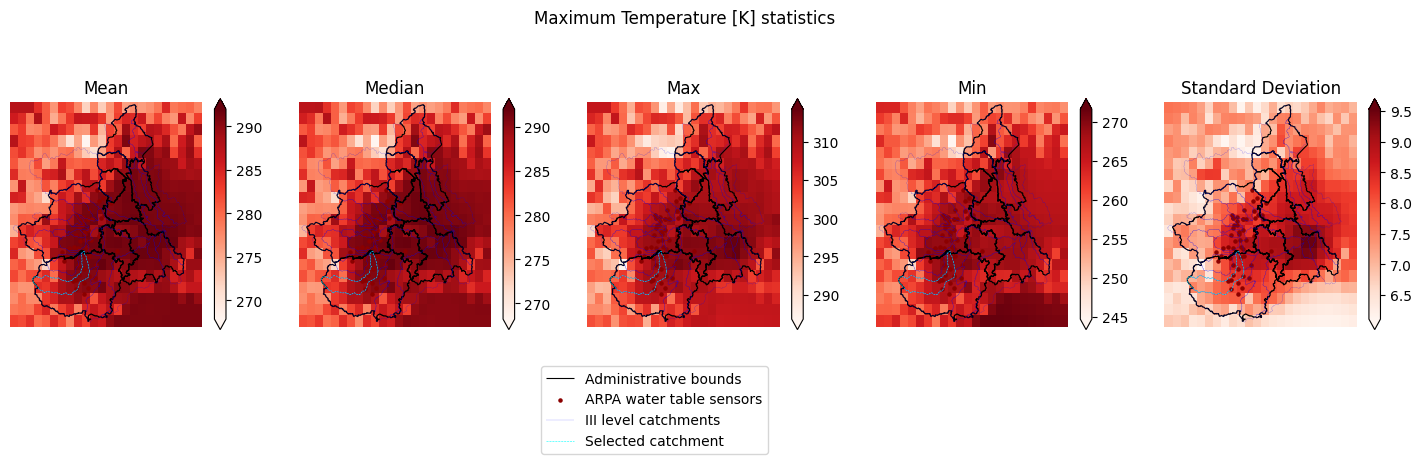

In [ ]:
stat_map_plots(meteorological_raster = meteorological_ds, variable = "tmax", region_shapefile = piemonte_borders,
               sensor_network_ds = arpa_wt_sensors, catchment_shapefile = catchment,
               selected_catchment = catchment_GM, cmap = "Reds", selected_catch_color = "cyan",
               plot_title = "Maximum Temperature [K] statistics")

In [ ]:
# SAVE WITH SAME SCALE AS TMIN
# stat_map_plots(meteorological_raster = meteorological_ds, variable = "tmax", region_shapefile = piemonte_borders,
#                sensor_network_ds = arpa_wt_sensors, catchment_shapefile = catchment,
#                selected_catchment = catchment_GM_V, cmap = "Reds", selected_catch_color = "cyan",
#                vmin = 245, vmax = 360, save = True, note_name = "_same_scale",
#                plot_title = "Maximum Temperature [K] statistics")

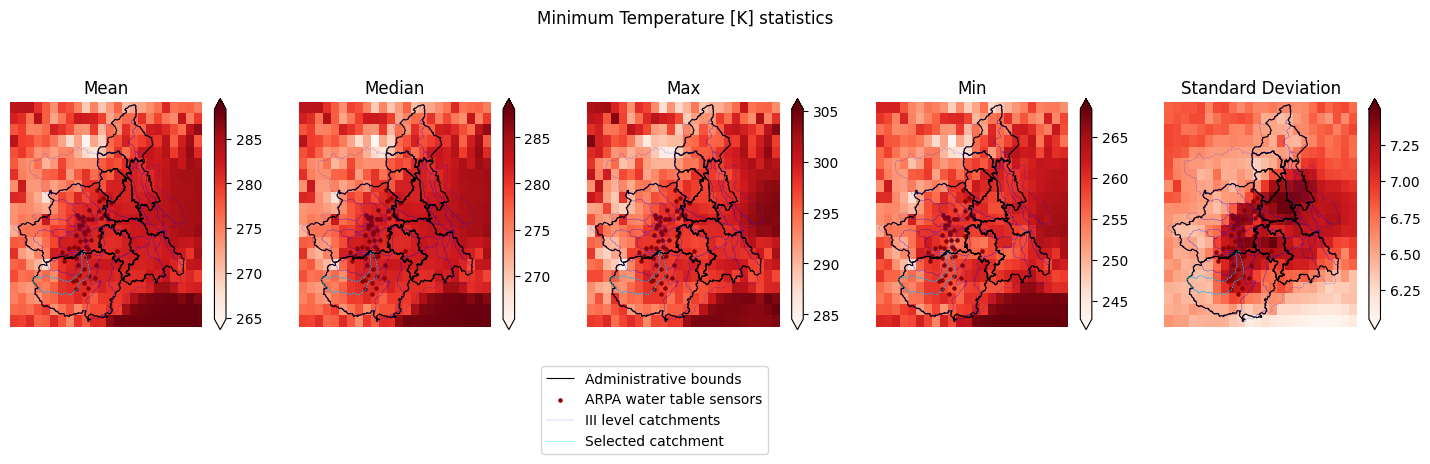

In [ ]:
stat_map_plots(meteorological_raster = meteorological_ds, variable = "tmin", region_shapefile = piemonte_borders,
               sensor_network_ds = arpa_wt_sensors, catchment_shapefile = catchment,
               selected_catchment = catchment_GM, cmap = "Reds", selected_catch_color = "cyan",
               plot_title = "Minimum Temperature [K] statistics")

In [ ]:
# # SAVE WITH SAME SCALE AS TMAX
# stat_map_plots(meteorological_raster = meteorological_ds, variable = "tmin", region_shapefile = piemonte_borders,
#                sensor_network_ds = arpa_wt_sensors, catchment_shapefile = catchment,
#                selected_catchment = catchment_GM_V, cmap = "Reds", selected_catch_color = "cyan",
#                vmin = 245, vmax = 360, save = True, note_name = "_same_scale",
#                plot_title = "Minimum Temperature [K] statistics")

### Missing value

In [25]:
max_na_xarrayds(meteorological_ds, "prec")

Max NAs pixel: 0 Percentage: 0.0
How many of them: 12496 in position: 0


In [ ]:
max_na_xarrayds(meteorological_ds, "tmax")

Max NAs pixel: 0 Percentage: 0.0
How many of them: 12496 in position: 0


In [ ]:
max_na_xarrayds(meteorological_ds, "tmin")

Max NAs pixel: 0 Percentage: 0.0
How many of them: 12496 in position: 0


In [ ]:
inspection_na(meteorological_ds, "prec", time_step = 6211)

Number of NAs: 0


### Plots

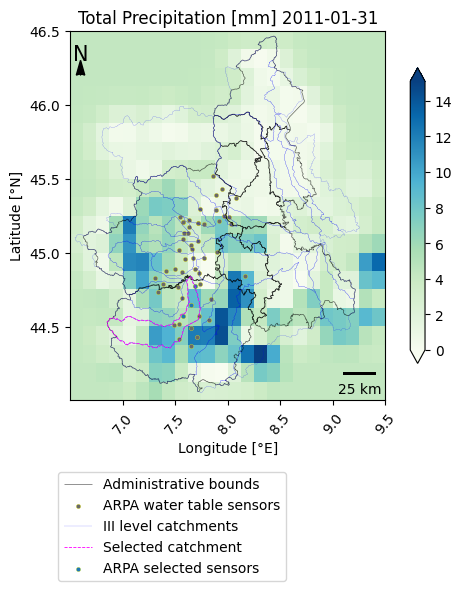

In [26]:
# Plot an image at a time_step
plot_map_at_a_time_step(meteorological_raster = meteorological_ds,
                        variable = "prec", time_step = 7700,
                        region_shapefile = piemonte_borders,
                        cmap = "GnBu", plot_title = "Total Precipitation [mm]",
                        sensor_network_ds = arpa_wt_sensors,
                        catchment_shapefile = catchment,
                        selected_catchment = catchment_GM,
                        selected_sensors = arpa_wt_sensors_GM,
                        sensor_network_color = "dimgray",
                        selected_catch_color = "magenta",
                        selected_sensors_color = "tab:blue",
                        selected_sensors_edgecolor = "yellow",
                        point_markersize = 10,
                        point_linewidths = 0.2,
                        write_sensor_labels = None,
                        map_bounds = None,
                        show_axes = True,
                        offset_legend = -0.15,
                        saving_path = None, file_name_add = "",
                        transparent = False,
                        spatial_resolution = spatial_resolution_meteo_long_1deg)

## Clip on catchments

Clip the meteorological raster on the Grana Maira catchment

In [27]:
# Retrieve the borders of the catchment from the shapefile
xmin_clip, ymin_clip, xmax_clip, ymax_clip = catchment_GM.total_bounds
# Extend the borders to include more pixel on the borders

increase = 0.05 # Degrees
#ymin_clip -= increase # not needed
xmin_clip += increase # "+" for subset for pixel included in the mask
xmax_clip += increase
#ymax_clip += increase # not needed

# Define a box around the Region of Interest (ROI)
ROI_box = box(xmin_clip, ymin_clip, xmax_clip , ymax_clip)

In [28]:
print("long min: ",xmin_clip)
print("lat min: ",ymin_clip)
print("long max: ",xmax_clip)
print("lat max: ",ymax_clip)

long min:  6.903760826450021
lat min:  44.35460555426311
long max:  7.788834900159712
lat max:  44.838563382777195


In [29]:
# Clip all the rasters
meteorological_ds_clip = meteorological_ds.rio.clip_box( minx = xmin_clip, maxx= xmax_clip , miny= ymin_clip , maxy= ymax_clip)
region_mask_clip = region_mask.rio.clip_box( minx = xmin_clip, maxx= xmax_clip , miny= ymin_clip , maxy= ymax_clip)
orography_clip = orography.rio.clip_box( minx = xmin_clip, maxx= xmax_clip , miny= ymin_clip , maxy= ymax_clip)
dtm_piemonte_clipped = dtm_piemonte.rio.clip_box( minx = xmin_clip, maxx= xmax_clip , miny= ymin_clip , maxy= ymax_clip)

### Plots

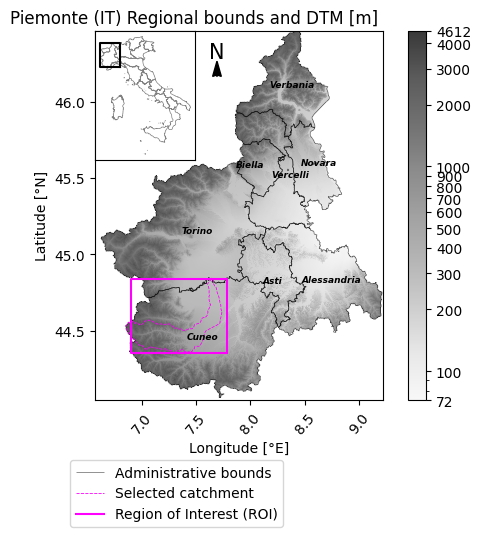

In [30]:
# Execution time around 2 minute
plot_static_map(region_shapefile = piemonte_borders,
                    plot_title = "Piemonte (IT) Regional bounds and DTM [m]",
                    province_labels = provinces_names,
                    province_coords = [provinces_long, provinces_lat],
                    dtm = dtm_piemonte,
                    cmap = grayscale_cmap("Reds"),
                    inner_ticks = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000],
                    sensor_network_ds = None,
                    catchment_shapefile = None,
                    selected_catchment = catchment_GM,
                    selected_sensors = None,
                    selected_catch_color = "magenta",
                    inset_object = [italy_borders, Piemonte_box.exterior.xy],
                    inset_bbox = [0,0.65,0.35,0.35],
                    ROI_box = ROI_box.exterior.xy,
                    selected_sensors_color = "yellow",
                    write_sensor_labels = None,
                    map_bounds = None,
                    show_axes = True,
                    offset_legend = -0.125,
                    transparent = True,
                    spatial_resolution = None,
                    north_x_shift = 1.05,
                    north_y_shift = -0.18,
                    north_fontsize = 15,
                    arrow_dx = 0,
                    arrow_dy = 0.1,
                    arrow_x_shift = 1.125,
                    arrow_y_shift = -0.3,
                    arrow_head_width=0.08,
                    arrow_head_length=0.1,
                    saving_path = None)
# f'{result_eda_GM_V_catchments}regional_bounds_dtm_focusGM.png'

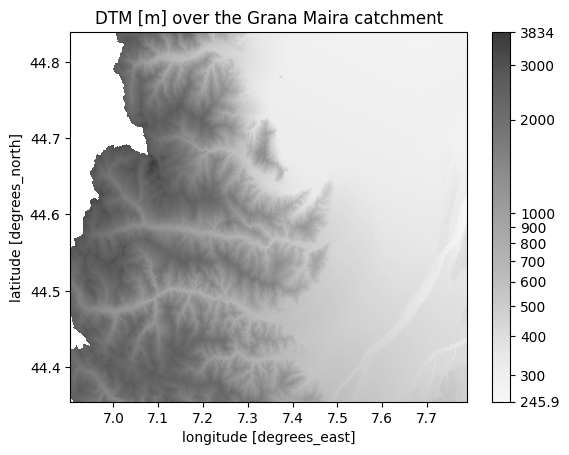

In [31]:
dtm_plot(dtm = dtm_piemonte_clipped, cmap = grayscale_cmap("Reds"),
         inner_ticks = [300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000],
         title = "DTM [m] over the Grana Maira catchment")

plt.show()

In [32]:
sensor_name_actual = copy.deepcopy(sensor_names)
sensor_name_actual

['Racconigi 00417910001', 'Savigliano 00421510001', 'Vottignasco 00425010001']

In [33]:
sensor_name_plot = [sensor_name_actual[i].replace(" ", "\n") for i in range(len(sensor_name_actual))]; sensor_name_plot

['Racconigi\n00417910001',
 'Savigliano\n00421510001',
 'Vottignasco\n00425010001']

In [ ]:
arpa_wt_sensors_GM

ID_code  C_code            Site        Munic  \
29  00417910001  GWB-S6   P13 Racconigi    Racconigi   
48  00421510001  GWB-S6   P6 Savigliano   Savigliano   
49  00425010001  GWB-S6  P5 Vottignasco  Vottignasco   

                                                  Loc       Start   End  \
29  Giardino pubblico Via B. Murialdo angolo Via S...  2009-01-01  None   
48          c/o Stadio "Ottavio Morino", V.le Gozzano  2009-01-01  None   
49                 c/o Cimitero comunale, Via Saluzzo  2009-01-01  None   

            Type Type_s  Mun_count         ID_Munic  wt_mean  \
29  Superficiale      S          3    Racconigi_S_3    4.513   
48  Superficiale      S          4   Savigliano_S_4    3.788   
49  Superficiale      S          2  Vottignasco_S_2    4.474   

                    geometry  
29  POINT (7.68794 44.77265)  
48  POINT (7.65242 44.64596)  
49  POINT (7.57503 44.57012)

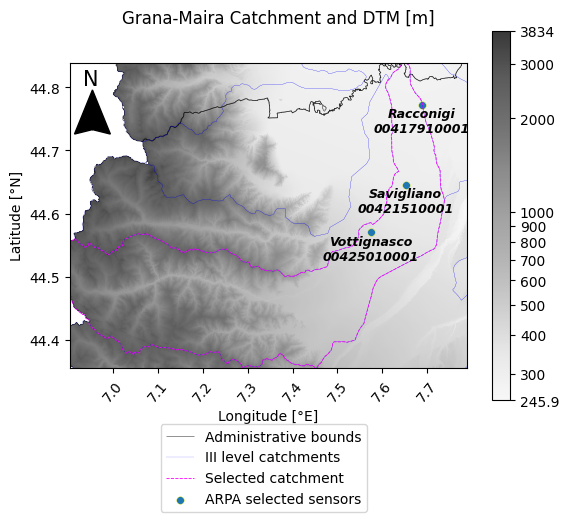

In [34]:
plot_static_map(region_shapefile = piemonte_borders,
                    plot_title = "Grana-Maira Catchment and DTM [m]",
                    province_labels = None,
                    province_coords = None,
                    dtm = dtm_piemonte_clipped,
                    cmap = grayscale_cmap("Reds"),
                    inner_ticks = [300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000],
                    sensor_network_ds = None,
                    catchment_shapefile = catchment,
                    selected_catchment = catchment_GM,
                    selected_sensors = arpa_wt_sensors_GM,
                    point_markersize = 30,
                    point_linewidths = 0.25,
                    write_sensor_labels = sensor_name_plot,
                    fontsize_sensor_label = 9,
                    x_shift_sensor_labels = [-0.0001 for i in range(len(sensor_name_plot))],
                    y_shift_sensor_labels = [-0.0001 for i in range(len(sensor_name_plot))],
                    map_bounds = None,
                    show_axes = True,
                    offset_legend = -0.05,
                    transparent = True,
                    spatial_resolution = None,
                    north_x_shift = 0.03,
                    north_y_shift = -0.035,
                    north_fontsize = 15,
                    arrow_dy = 0.007,
                    arrow_dx = 0,
                    arrow_x_shift = 0.05,
                    arrow_y_shift = -0.05,
                    arrow_head_width=0.08,
                    arrow_head_length=0.07,
                    saving_path = None)

# f'{result_eda_wt_meteo_path}regional_bounds_dtm_focusGM_zoom.png'

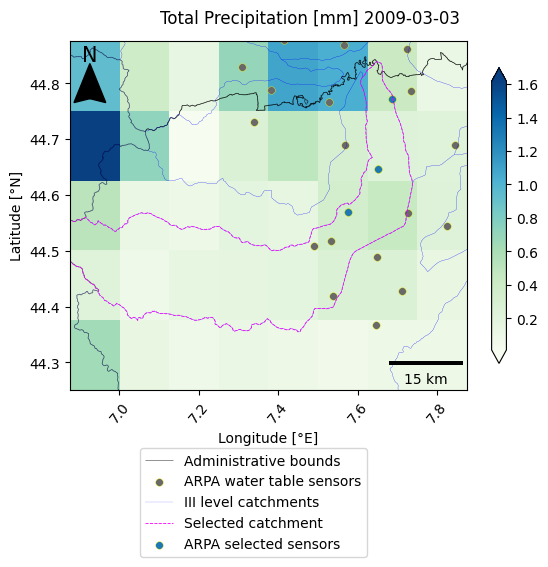

In [35]:
plot_map_at_a_time_step(meteorological_raster = meteorological_ds_clip,
                        variable = "prec", time_step = 7001,
                        region_shapefile = piemonte_borders,
                        cmap = "GnBu", plot_title = "Total Precipitation [mm]",
                        sensor_network_ds = arpa_wt_sensors,
                        catchment_shapefile = catchment,
                        selected_catchment = catchment_GM,
                        selected_sensors = arpa_wt_sensors_GM,
                        sensor_network_color = "dimgray",
                        selected_catch_color = "magenta",
                        selected_sensors_color = "tab:blue",
                        selected_sensors_edgecolor = "yellow",
                        point_markersize = 30,
                        point_linewidths = 0.25,
                        write_sensor_labels = None,
                        map_bounds = None,
                        show_axes = True,
                        offset_legend = -0.1,
                        saving_path = None, file_name_add = "",
                        transparent = False,
                        spatial_resolution = spatial_resolution_meteo_long_1deg,
                        north_x_shift = 0.03,
                        north_y_shift = -0.035,
                        north_fontsize = 15,
                        arrow_dy = 0.01,
                        arrow_x_shift = 0.05,
                        arrow_y_shift = -0.05,
                        arrow_head_width=0.08,
                        arrow_head_length=0.07)

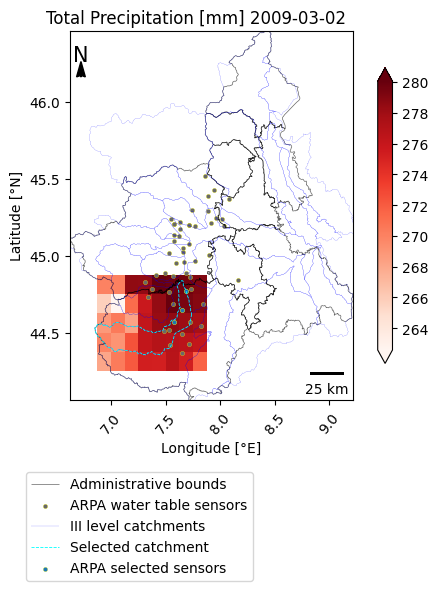

In [36]:
plot_map_at_a_time_step(meteorological_raster = meteorological_ds_clip,
                        variable = "tmin", time_step = 7000,
                        region_shapefile = piemonte_borders,
                        cmap = "Reds", plot_title = "Total Precipitation [mm]",
                        sensor_network_ds = arpa_wt_sensors,
                        catchment_shapefile = catchment,
                        selected_catchment = catchment_GM,
                        selected_sensors = arpa_wt_sensors_GM,
                        sensor_network_color = "dimgray",
                        selected_catch_color = "cyan",
                        selected_sensors_color = "tab:blue",
                        selected_sensors_edgecolor = "yellow",
                        point_markersize = 10,
                        point_linewidths = 0.2,
                        write_sensor_labels = None,
                        map_bounds = [(piemonte_long_min, piemonte_long_max), (piemonte_lat_min, piemonte_lat_max)],
                        show_axes = True,
                        offset_legend = -0.15,
                        saving_path = None, file_name_add = "",
                        transparent = False,
                        spatial_resolution = spatial_resolution_meteo_long_1deg)

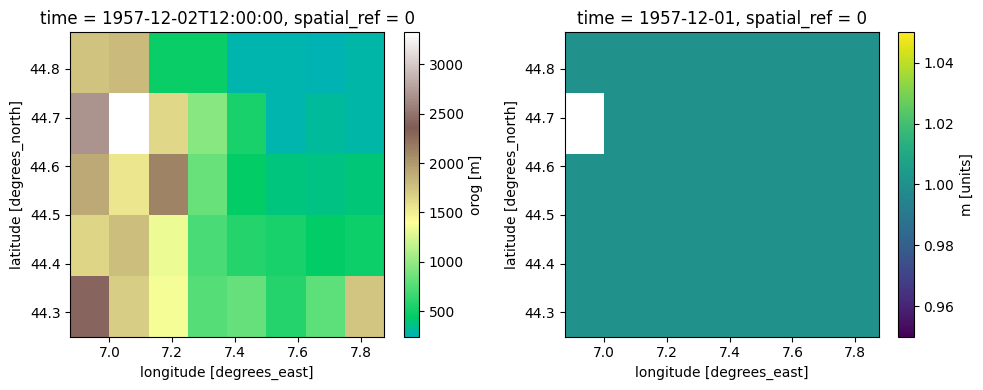

In [37]:
# Plot the clipped orography raster and the clipped mask given
# by ARPA
fig, axs = plt.subplots(1, 2, figsize = (10,4))

orography_clip["orog"].plot(ax = axs[0], cmap = cropped_cmap)
region_mask_clip["m"].plot(ax = axs[1])

fig.tight_layout()
plt.show()

### Statistics

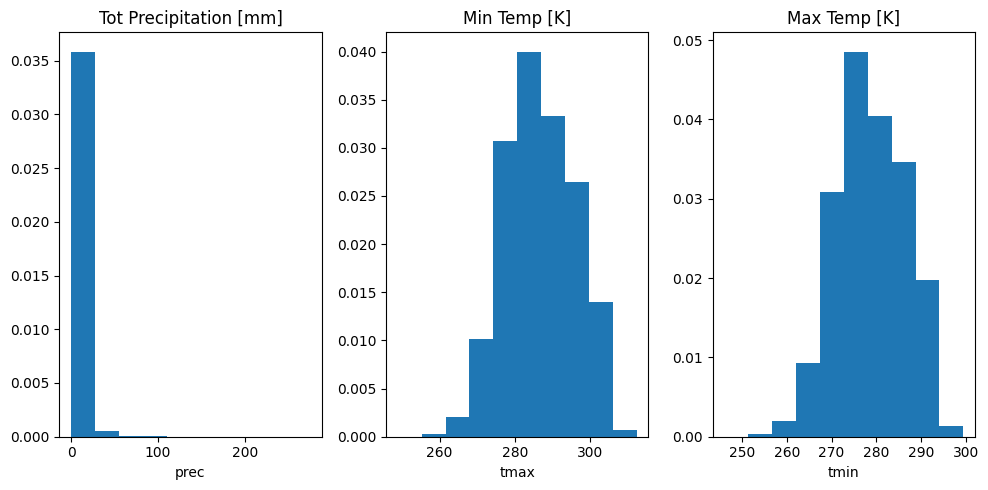

In [38]:
sample_density_plot(meteorological_ds_clip)

### Statistics - spatial dimension

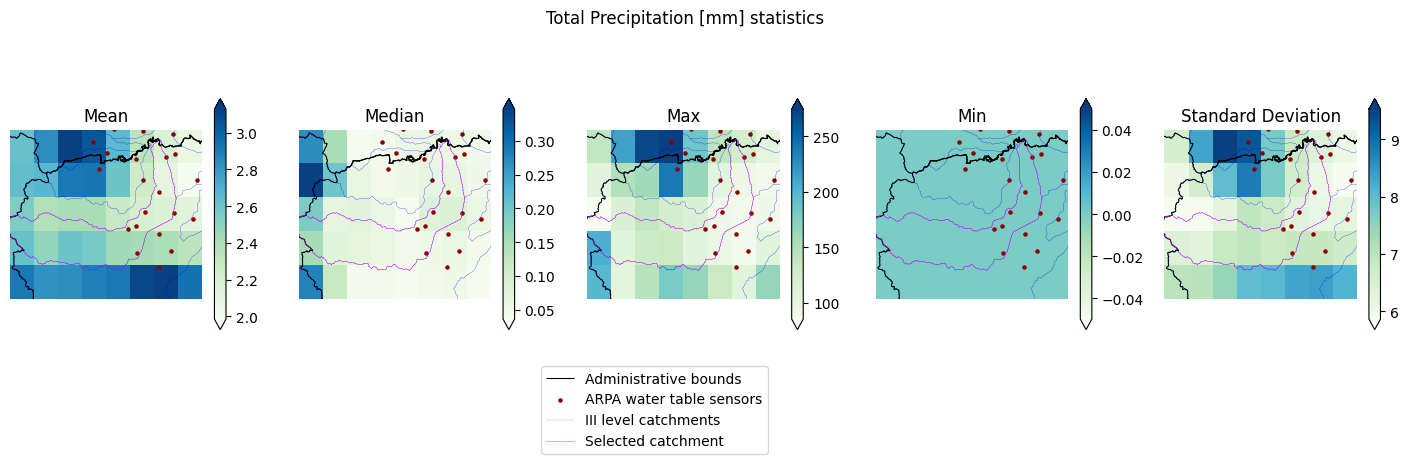

In [39]:
stat_map_plots(meteorological_raster = meteorological_ds_clip, variable = "prec", region_shapefile = piemonte_borders,
               sensor_network_ds = arpa_wt_sensors, catchment_shapefile = catchment,
               selected_catchment = catchment_GM, cmap = "GnBu", plot_title="Total Precipitation [mm] statistics")

#stat_map_plots(0, "Blues",meteo_dataset = meteorological_ds_clip, zoom = True) #, vmin = 245, vmax = 360, save = True, note_name = "_same_scale"

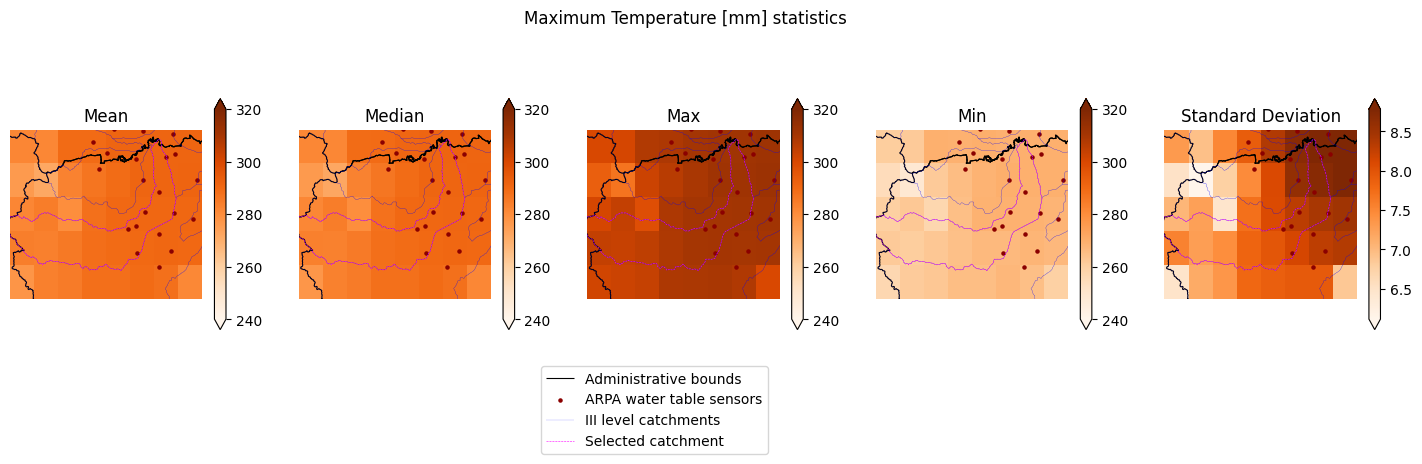

In [ ]:
stat_map_plots(meteorological_raster = meteorological_ds_clip, variable = "tmax", region_shapefile = piemonte_borders,
               sensor_network_ds = arpa_wt_sensors, catchment_shapefile = catchment,
               selected_catchment = catchment_GM, cmap = "Oranges", plot_title="Maximum Temperature [mm] statistics",
               vmin = 240, vmax = 320)

#stat_map_plots(1, "Oranges",meteo_dataset = meteorological_ds_clip, zoom = True, vmin = 240, vmax = 320)

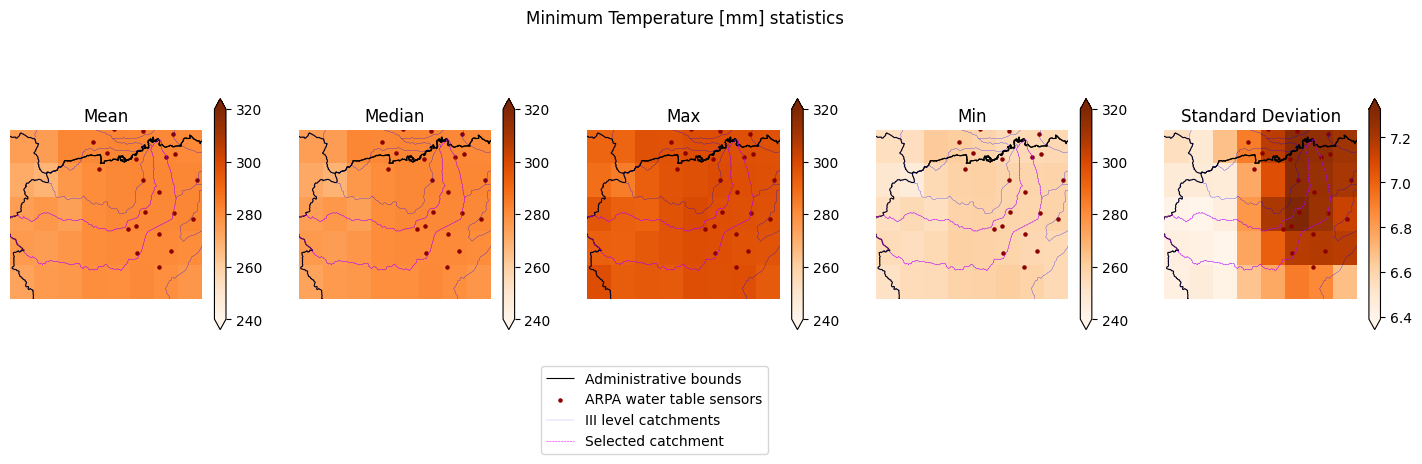

In [ ]:
stat_map_plots(meteorological_raster = meteorological_ds_clip, variable = "tmin", region_shapefile = piemonte_borders,
               sensor_network_ds = arpa_wt_sensors, catchment_shapefile = catchment,
               selected_catchment = catchment_GM, cmap = "Oranges", plot_title="Minimum Temperature [mm] statistics",
               vmin = 240, vmax = 320)

#stat_map_plots(2, "Oranges",meteo_dataset = meteorological_ds_clip, zoom = True, vmin = 240, vmax = 320)

### Statistics - time dimension

#### prec

In [ ]:
# Construct useful dataframe to make the plots

df_prec = meteorological_ds_clip["prec"].mean(axis = (1,2)).drop("spatial_ref").to_dataframe()
df_prec["time"] = df_prec.index

df_prec_months = copy.deepcopy(df_prec)
df_prec_years = copy.deepcopy(df_prec)
df_prec_years_means = copy.deepcopy(df_prec)

df_prec_months["month"] = df_prec_months.time.dt.month

df_prec_years["year"] = df_prec_years.time.dt.year
df_prec_years_means = df_prec_years.groupby("year").mean(numeric_only = True)
df_prec_years_means["year"] = df_prec_years_means.index

<ipython-input-86-34f8243e2e2a>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45)


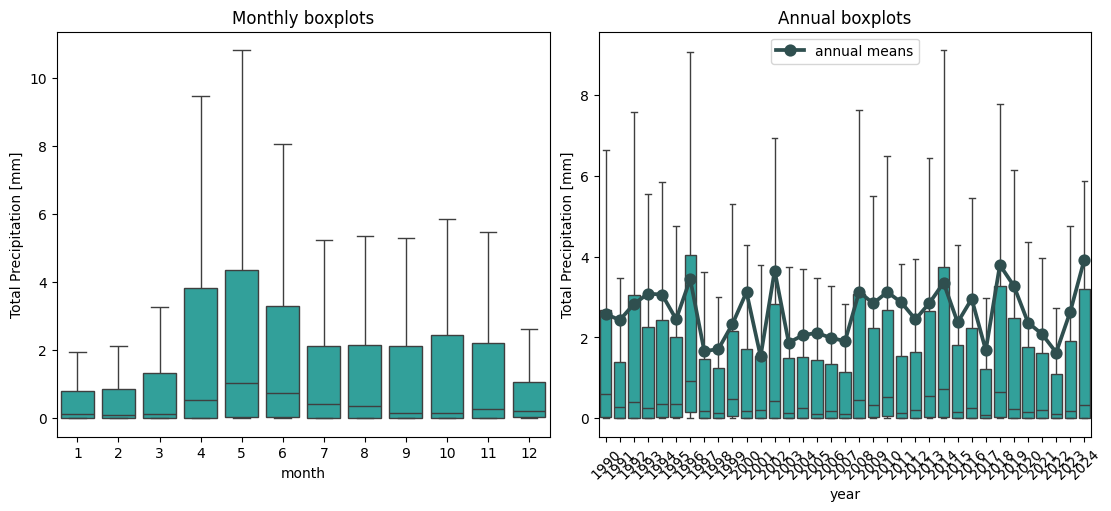

In [ ]:
fig, ax = plt.subplots(1,2, constrained_layout = True, figsize = (11,5))
#fig.set_size_inches((12,4))


sns.boxplot(x='month',y='prec',data=df_prec_months,ax=ax[0], showfliers=False, color = 'lightseagreen')
ax[0].set(ylabel = "Total Precipitation [mm]")
ax[0].set_title("Monthly boxplots")

sns.boxplot(x='year',y='prec',data=df_prec_years,ax=ax[1], showfliers=False, color = 'lightseagreen')
sns.pointplot(x='year', y='prec', data=df_prec_years_means, ax=ax[1] , label="annual means", color = "darkslategray")
ax[1].set(ylabel = "Total Precipitation [mm]")
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45)
ax[1].set_title("Annual boxplots")
ax[1].legend()



#plt.savefig(result_eda_GM_V_catchments + "Grana_Maira_tot_prec_m_y_box_plots_ARPA.png", dpi=400, bbox_inches = 'tight')
plt.show()

In [ ]:
# Let's look at the splits (they are defined in the script about model training)

# test
df_prec_test = df_prec.loc[df_prec["time"] >= np.datetime64('2022-01-01')]
df_prec_test_months = copy.deepcopy(df_prec_test)
df_prec_test_months["month"] = df_prec_test_months.time.dt.month
# training
df_prec_train = df_prec.loc[df_prec["time"] < np.datetime64('2022-01-01')]
df_prec_train_months = copy.deepcopy(df_prec_train)
df_prec_train_months["month"] = df_prec_train_months.time.dt.month
# last 12 weeks
df_prec_last_12week = df_prec.loc[(df_prec["time"] >= np.datetime64('2023-06-01')) & ((df_prec["time"] < np.datetime64('2023-10-01')))]
df_prec_last_12week_months = copy.deepcopy(df_prec_last_12week)
df_prec_last_12week_months["month"] = df_prec_last_12week_months.time.dt.month

In [ ]:
df_prec_test = df_prec_test.set_index('time').groupby([pd.Grouper(freq="W")]).mean()
df_prec_train = df_prec_train.set_index('time').groupby([pd.Grouper(freq="W")]).mean()
df_prec_last_12week = df_prec_last_12week.set_index('time').groupby([pd.Grouper(freq="W")]).mean()

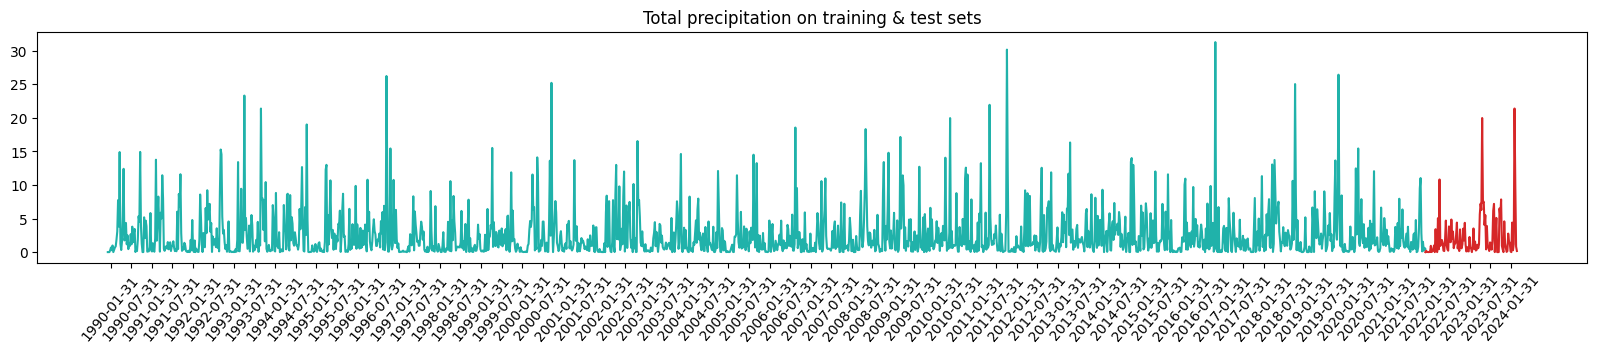

In [ ]:
plt.figure(figsize = (20,3))
plt.plot(df_prec_train["prec"], color = 'lightseagreen')
plt.plot(df_prec_test["prec"], color = "tab:red")
plt.xticks(pd.date_range(df_prec_train.index.min(), df_prec_test.index.max(), normalize = True, freq="6M", inclusive = "both"),  rotation = 50)
plt.title("Total precipitation on training & test sets")
plt.show()

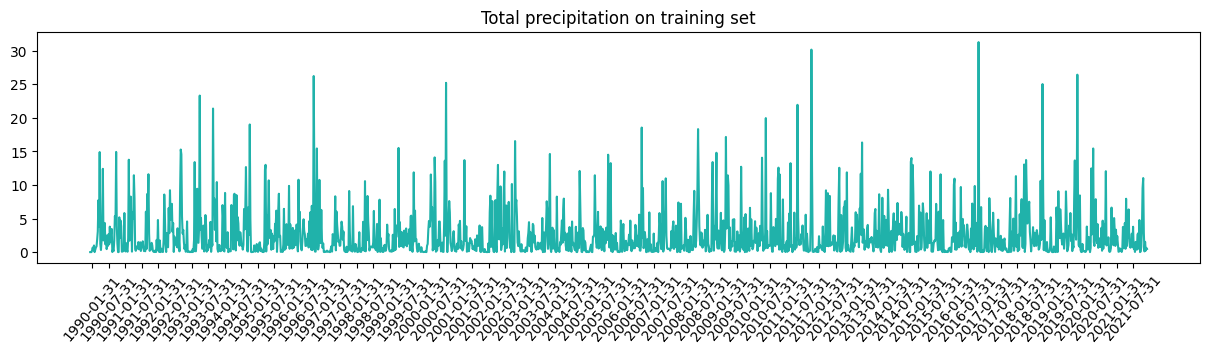

In [ ]:
plt.figure(figsize = (15,3))
plt.plot(df_prec_train["prec"], color = 'lightseagreen')
plt.xticks(pd.date_range(df_prec_train.index.min(), df_prec_train.index.max(), normalize = True, freq="6M", inclusive = "both"),  rotation = 50)
plt.title("Total precipitation on training set")
plt.show()

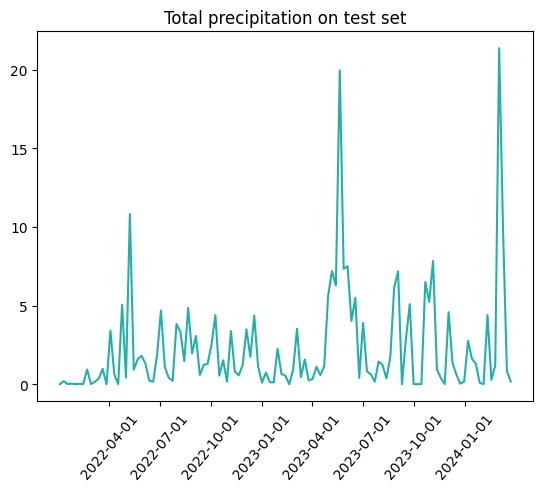

In [ ]:
plt.plot(df_prec_test["prec"], color = 'lightseagreen')
plt.xticks(pd.date_range(df_prec_test.index.min(), df_prec_test.index.max(), normalize = True, freq="QS", inclusive = "both"),  rotation = 50)
plt.title("Total precipitation on test set")
plt.show()

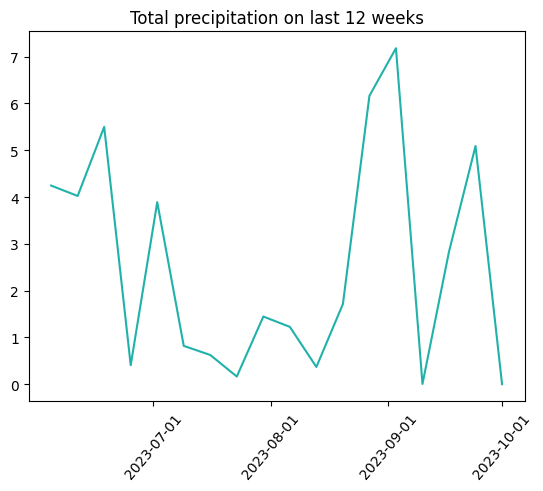

In [ ]:
plt.plot(df_prec_last_12week["prec"], color = 'lightseagreen')
plt.xticks(pd.date_range(df_prec_last_12week.index.min(), df_prec_last_12week.index.max(), normalize = True, freq="MS", inclusive = "both"),  rotation = 50)
plt.title("Total precipitation on last 12 weeks")
plt.show()

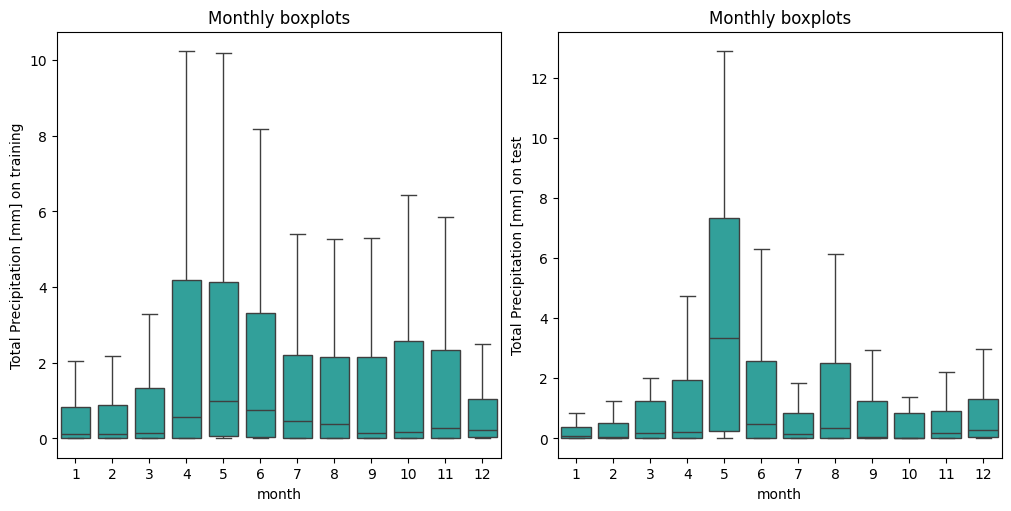

In [ ]:
fig, ax = plt.subplots(1,2, constrained_layout = True, figsize = (10,5))
#fig.set_size_inches((12,4))


sns.boxplot(x='month',y='prec',data=df_prec_train_months,ax=ax[0], showfliers=False, color = 'lightseagreen')
ax[0].set(ylabel = "Total Precipitation [mm] on training")
ax[0].set_title("Monthly boxplots")

sns.boxplot(x='month',y='prec',data=df_prec_test_months,ax=ax[1], showfliers=False, color = 'lightseagreen')
ax[1].set(ylabel = "Total Precipitation [mm] on test")
ax[1].set_title("Monthly boxplots")

#plt.savefig(result_eda_GM_V_catchments + "Grana_Maira_tot_prec_m_y_box_plots_ARPA.png", dpi=400, bbox_inches = 'tight')
plt.show()

#### tmax

In [ ]:
# Construct useful dataframe to make the plots

df_tmax = meteorological_ds_clip["tmax"].mean(axis = (1,2)).drop("spatial_ref").to_dataframe()
df_tmax["time"] = df_tmax.index

df_tmax_months = copy.deepcopy(df_tmax)
df_tmax_years = copy.deepcopy(df_tmax)
df_tmax_years_means = copy.deepcopy(df_tmax)

df_tmax_months["month"] = df_tmax_months.time.dt.month

df_tmax_years["year"] = df_tmax_years.time.dt.year
df_tmax_years_means = df_tmax_years.groupby("year").mean(numeric_only = True)
df_tmax_years_means["year"] = df_tmax_years_means.index

<ipython-input-95-39bc4847de55>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45)


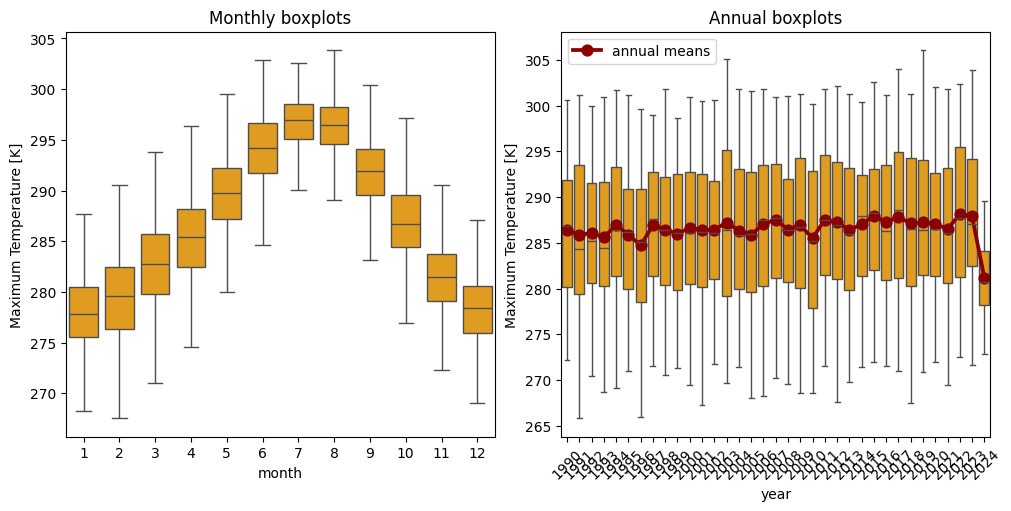

In [ ]:
fig, ax = plt.subplots(1,2, constrained_layout = True, figsize = (10,5))
#fig.set_size_inches((12,4))


sns.boxplot(x='month',y='tmax',data=df_tmax_months,ax=ax[0], showfliers=False, color = "orange")
ax[0].set(ylabel = "Maximum Temperature [K]")
ax[0].set_title("Monthly boxplots")

sns.boxplot(x='year',y='tmax',data=df_tmax_years,ax=ax[1], showfliers=False, color = "orange")
sns.pointplot(x='year', y='tmax', data=df_tmax_years_means, ax=ax[1] , label="annual means", color = "darkred")
ax[1].set(ylabel = "Maximum Temperature [K]")
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45)
ax[1].set_title("Annual boxplots")
ax[1].legend()



#plt.savefig(result_eda_GM_V_catchments + "Grana_Maira_tot_prec_m_y_box_plots_ARPA.png", dpi=400, bbox_inches = 'tight')
plt.show()

In [ ]:
# test
df_tmax_test = df_tmax.loc[df_tmax["time"] >= np.datetime64('2022-01-01')]
df_tmax_test_months = copy.deepcopy(df_tmax_test)
df_tmax_test_months["month"] = df_tmax_test_months.time.dt.month
# training
df_tmax_train = df_tmax.loc[df_tmax["time"] < np.datetime64('2022-01-01')]
df_tmax_train_months = copy.deepcopy(df_tmax_train)
df_tmax_train_months["month"] = df_tmax_train_months.time.dt.month

In [ ]:
df_tmax_test = df_tmax_test.set_index('time').groupby([pd.Grouper(freq="W")]).mean()
df_tmax_train = df_tmax_train.set_index('time').groupby([pd.Grouper(freq="W")]).mean()

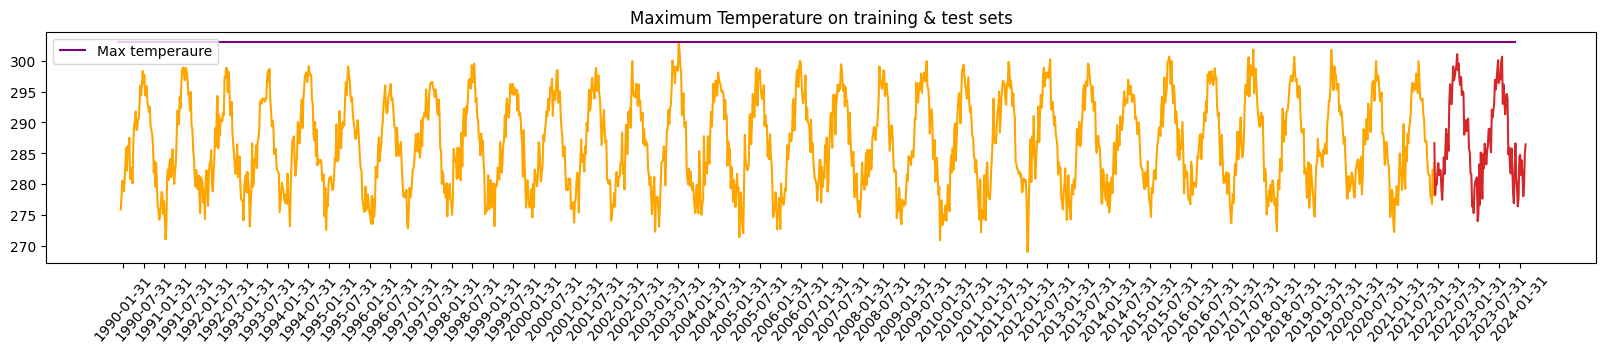

In [ ]:
plt.figure(figsize = (20,3))
plt.plot(df_tmax_train["tmax"], color = "orange")
plt.plot(df_tmax_test["tmax"], color = "tab:red")
plt.xticks(pd.date_range(df_tmax_train.index.min(), df_tmax_test.index.max(), normalize = True, freq="6M", inclusive = "both"),  rotation = 50)
plt.hlines(y = max(df_tmax_test["tmax"].max(), df_tmax_train["tmax"].max()), color = "purple", xmin = np.datetime64('1989-12-01'), xmax = np.datetime64('2024-01-01'), label = "Max temperaure")
plt.legend()
plt.title("Maximum Temperature on training & test sets")
plt.show()

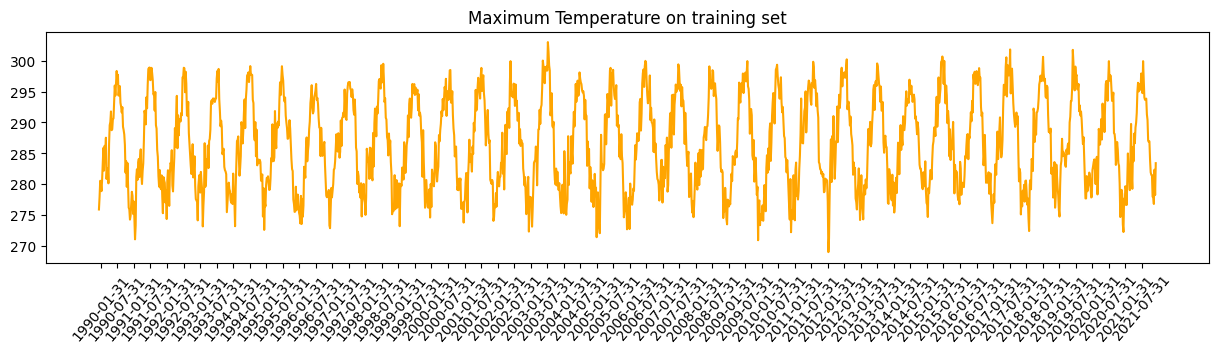

In [ ]:
plt.figure(figsize = (15,3))
plt.plot(df_tmax_train["tmax"], color = "orange")
plt.xticks(pd.date_range(df_tmax_train.index.min(), df_tmax_train.index.max(), normalize = True, freq="6M", inclusive = "both"),  rotation = 50)
plt.title("Maximum Temperature on training set")
plt.show()

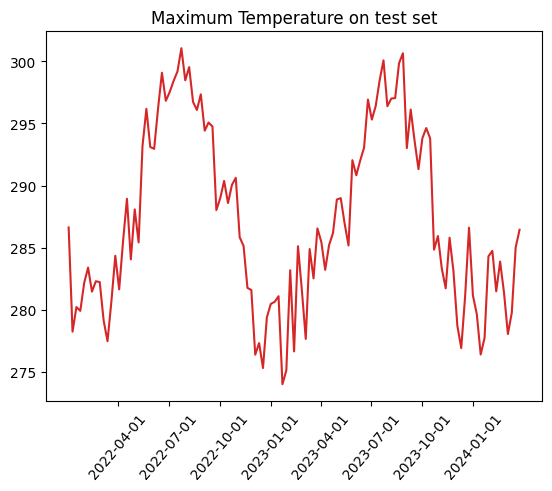

In [ ]:
plt.plot(df_tmax_test["tmax"], color = "tab:red")
plt.xticks(pd.date_range(df_tmax_test.index.min(), df_tmax_test.index.max(), normalize = True, freq="QS", inclusive = "both"),  rotation = 50)
plt.title("Maximum Temperature on test set")
plt.show()

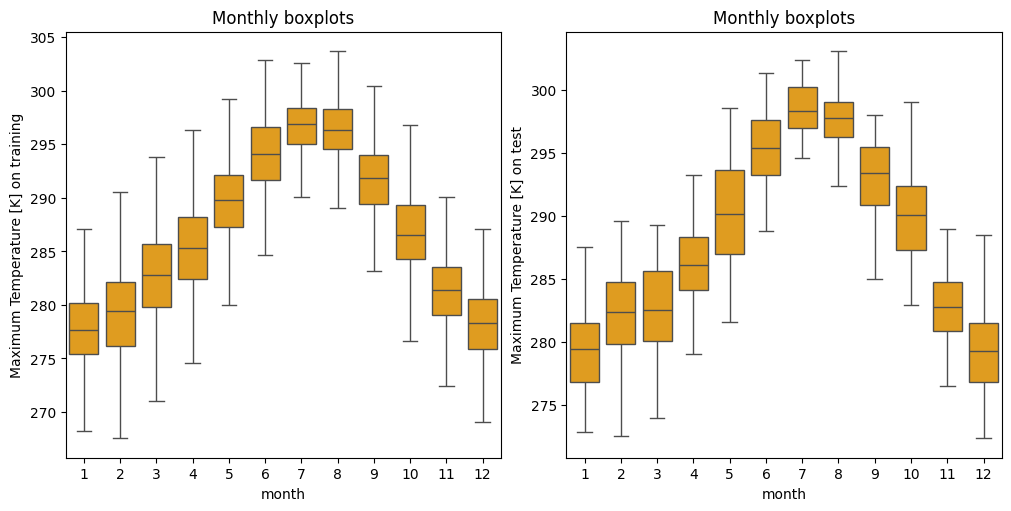

In [ ]:
fig, ax = plt.subplots(1,2, constrained_layout = True, figsize = (10,5))
#fig.set_size_inches((12,4))


sns.boxplot(x='month',y='tmax',data=df_tmax_train_months,ax=ax[0], showfliers=False, color = "orange")
ax[0].set(ylabel = "Maximum Temperature [K] on training")
ax[0].set_title("Monthly boxplots")

sns.boxplot(x='month',y='tmax',data=df_tmax_test_months,ax=ax[1], showfliers=False, color = "orange")
ax[1].set(ylabel = "Maximum Temperature [K] on test")
ax[1].set_title("Monthly boxplots")

#plt.savefig(result_eda_GM_V_catchments + "Grana_Maira_tot_prec_m_y_box_plots_ARPA.png", dpi=400, bbox_inches = 'tight')
plt.show()

#### tmin

In [ ]:
# Construct useful dataframe to make the plots

df_tmin = meteorological_ds_clip["tmin"].mean(axis = (1,2)).drop("spatial_ref").to_dataframe()
df_tmin["time"] = df_tmin.index

df_tmin_months = copy.deepcopy(df_tmin)
df_tmin_years = copy.deepcopy(df_tmin)
df_tmin_years_means = copy.deepcopy(df_tmin)

df_tmin_months["month"] = df_tmin_months.time.dt.month

df_tmin_years["year"] = df_tmin_years.time.dt.year
df_tmin_years_means = df_tmin_years.groupby("year").mean(numeric_only = True)
df_tmin_years_means["year"] = df_tmin_years_means.index

<ipython-input-103-8982127a2ea1>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45)


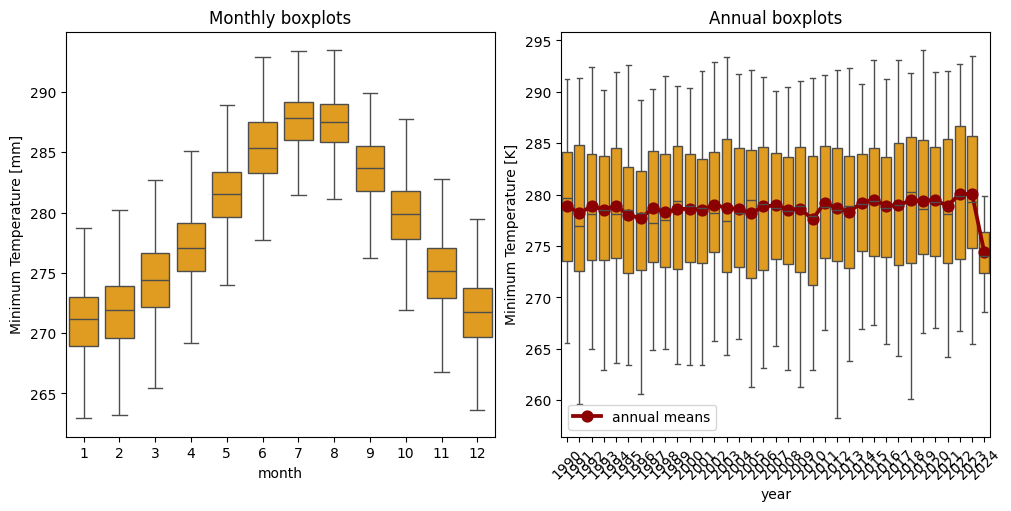

In [ ]:
fig, ax = plt.subplots(1,2, constrained_layout = True, figsize = (10,5))
#fig.set_size_inches((12,4))


sns.boxplot(x='month',y='tmin',data=df_tmin_months,ax=ax[0], showfliers=False, color = "orange")
ax[0].set(ylabel = "Minimum Temperature [mm]")
ax[0].set_title("Monthly boxplots")

sns.boxplot(x='year',y='tmin',data=df_tmin_years,ax=ax[1], showfliers=False, color = "orange")
sns.pointplot(x='year', y='tmin', data=df_tmin_years_means, ax=ax[1] , label="annual means", color = "darkred")
ax[1].set(ylabel = "Minimum Temperature [K]")
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45)
ax[1].set_title("Annual boxplots")
ax[1].legend()



#plt.savefig(result_eda_GM_V_catchments + "Grana_Maira_tot_prec_m_y_box_plots_ARPA.png", dpi=400, bbox_inches = 'tight')
plt.show()

In [ ]:
# test
df_tmin_test = df_tmin.loc[df_tmin["time"] >= np.datetime64('2022-01-01')]
df_tmin_test_months = copy.deepcopy(df_tmin_test)
df_tmin_test_months["month"] = df_tmin_test_months.time.dt.month
# training
df_tmin_train = df_tmin.loc[df_tmin["time"] < np.datetime64('2022-01-01')]
df_tmin_train_months = copy.deepcopy(df_tmin_train)
df_tmin_train_months["month"] = df_tmin_train_months.time.dt.month

In [ ]:
df_tmin_test = df_tmin_test.set_index('time').groupby([pd.Grouper(freq="W")]).mean()
df_tmin_train = df_tmin_train.set_index('time').groupby([pd.Grouper(freq="W")]).mean()

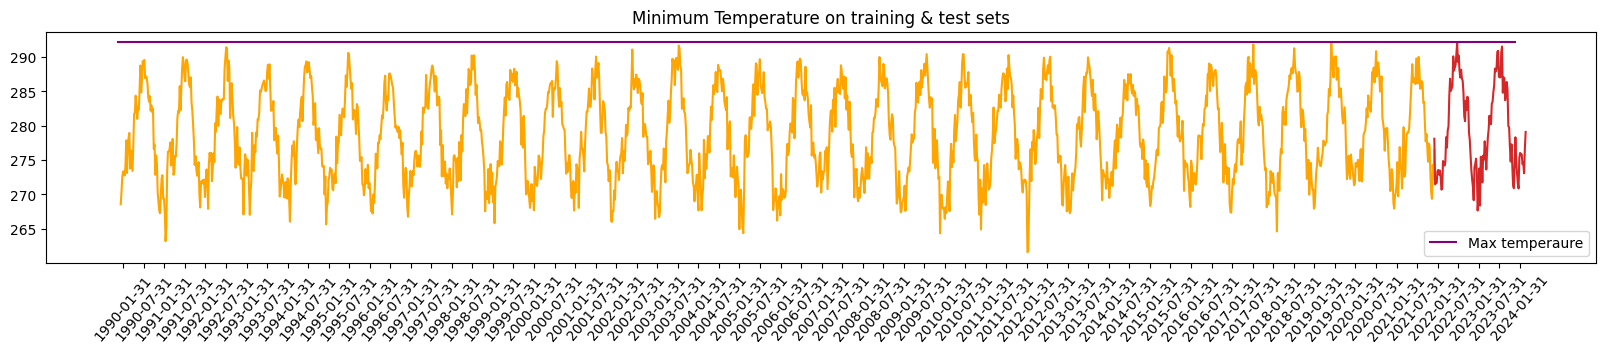

In [ ]:
plt.figure(figsize = (20,3))
plt.plot(df_tmin_train["tmin"], color = "orange")
plt.plot(df_tmin_test["tmin"], color = "tab:red")
plt.xticks(pd.date_range(df_tmin_train.index.min(), df_tmin_test.index.max(), normalize = True, freq="6M", inclusive = "both"),  rotation = 50)
plt.hlines(y = max(df_tmin_test["tmin"].max(), df_tmin_train["tmin"].max()), color = "purple", xmin = np.datetime64('1989-12-01'), xmax = np.datetime64('2024-01-01'), label = "Max temperaure")
plt.legend()
plt.title("Minimum Temperature on training & test sets")
plt.show()

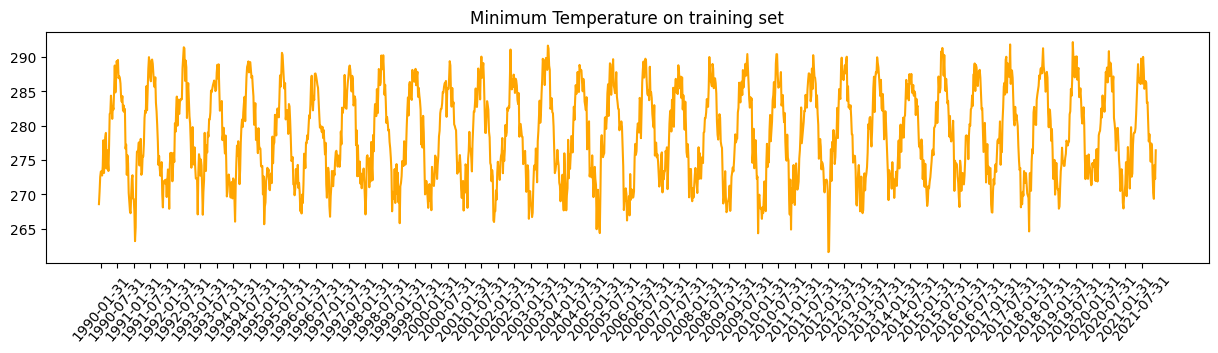

In [ ]:
plt.figure(figsize = (15,3))
plt.plot(df_tmin_train["tmin"], color = "orange")
plt.xticks(pd.date_range(df_tmin_train.index.min(), df_tmin_train.index.max(), normalize = True, freq="6M", inclusive = "both"),  rotation = 50)
plt.title("Minimum Temperature on training set")
plt.show()

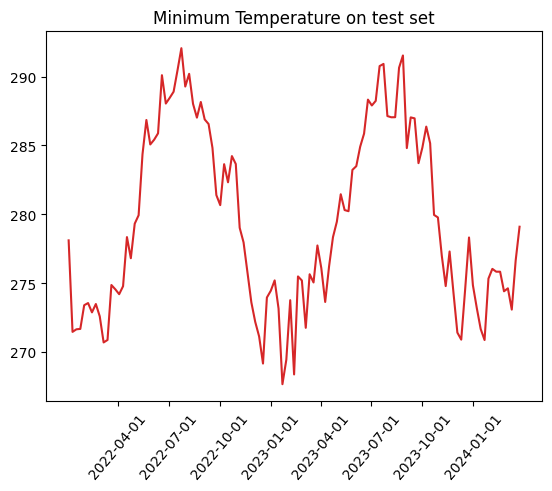

In [ ]:
plt.plot(df_tmin_test["tmin"], color = "tab:red")
plt.xticks(pd.date_range(df_tmin_test.index.min(), df_tmin_test.index.max(), normalize = True, freq="QS", inclusive = "both"),  rotation = 50)
plt.title("Minimum Temperature on test set")
plt.show()

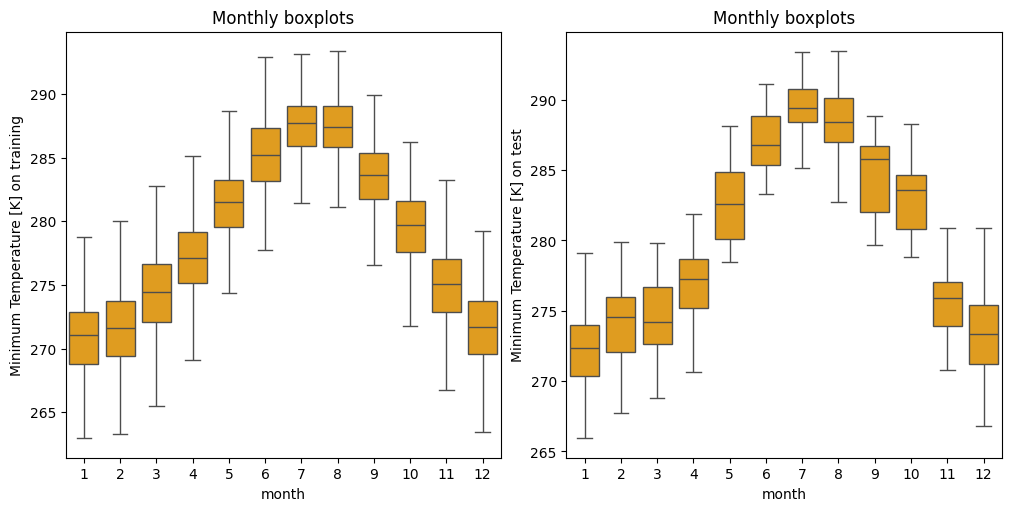

In [ ]:
fig, ax = plt.subplots(1,2, constrained_layout = True, figsize = (10,5))
#fig.set_size_inches((12,4))


sns.boxplot(x='month',y='tmin',data=df_tmin_train_months,ax=ax[0], showfliers=False, color = "orange")
ax[0].set(ylabel = "Minimum Temperature [K] on training")
ax[0].set_title("Monthly boxplots")

sns.boxplot(x='month',y='tmin',data=df_tmin_test_months,ax=ax[1], showfliers=False, color = "orange")
ax[1].set(ylabel = "Minimum Temperature [K] on test")
ax[1].set_title("Monthly boxplots")

#plt.savefig(result_eda_GM_V_catchments + "Grana_Maira_tot_prec_m_y_box_plots_ARPA.png", dpi=400, bbox_inches = 'tight')
plt.show()

#### check consistency tmin tmax

In [ ]:
np.equal(df_tmin["time"].values, df_tmax["time"].values).all()

True

In [ ]:
np.greater(df_tmax["tmax"].values, df_tmin["tmin"].values).all()

True

### Save clipped dataset

In [ ]:
meteo_data_path

In [ ]:
# UNCOMMENT TO SAVE
#meteorological_ds_clip.drop("spatial_ref").to_netcdf(meteo_data_path + 'meteo_data_ARPA_GM_clipped.nc')

# Water Table Depth

Raw data were retrieved by direct request to ARPA

In [40]:
sensor_time_series_file_names = os.listdir(water_table_time_series_raw_path)

# select only .csv files
csv_files = [re.search(r'.*(\.csv)$', sensor_time_series_file_names[i]) for i in range(len(sensor_time_series_file_names))]
sensor_time_series_file_names = [sensor_time_series_file_names[i] for i in range(len(sensor_time_series_file_names)) if csv_files[i] != None]; sensor_time_series_file_names

['Savigliano-00421510001.csv',
 'Vottignasco-00425010001.csv',
 'Racconigi-00417910001.csv']

In [42]:
# Create titles from the file names, it will be used as title for the selected sensor's plots

sensor_titles = [sensor_time_series_file_names[i].replace("-", " ") for i in range(0,len(sensor_time_series_file_names))]
sensor_titles = [sensor_titles[i].replace(".csv", " ") for i in range(0,len(sensor_titles))]
sensor_titles = [re.search(r'[A-Za-z]+\s\d+\s', sensor_titles[i]).group() +"Water Table Depth [m]" for i in range(0,len(sensor_titles))]
sensor_titles

['Savigliano 00421510001 Water Table Depth [m]',
 'Vottignasco 00425010001 Water Table Depth [m]',
 'Racconigi 00417910001 Water Table Depth [m]']

In [43]:
# load each time series into an element of a dictionary. Keys are the ID codes of the sensors
water_table_depth_ts_GM_dictionary = load_ts_in_dictionary(directory = water_table_time_series_raw_path,
                                                list_name = sensor_time_series_file_names)

In [44]:
water_table_depth_ts_GM_dictionary['00421510001']

codice_parametro_arpa categoria_parametro_arpa codice_punto data_misura  \
0                    P00010                        A  00421510001  2001-02-23   
1                    P00010                        A  00421510001  2001-02-23   
2                    P00010                        A  00421510001  2001-02-24   
3                    P00010                        A  00421510001  2001-02-24   
4                    P00010                        A  00421510001  2001-02-24   
...                     ...                      ...          ...         ...   
20815                P00010                        A  00421510001  2023-12-30   
20816                P00010                        A  00421510001  2023-12-30   
20817                P00010                        A  00421510001  2023-12-31   
20818                P00010                        A  00421510001  2023-12-31   
20819                P00010                        A  00421510001  2023-12-31   

      ora_misura  anno_monitoraggio  valore  valore_validato gwbregcod  \
0       00:00:00               2001    3.68             3.68    GWB-S6   
1       18:00:00               2001    3.67             3.67    GWB-S6   
2       00:00:00               2001    3.68             3.68    GWB-S6   
3       06:00:00               2001    3.67             3.67    GWB-S6   
4       12:00:00               2001    3.68             3.68    GWB-S6   
...          ...                ...     ...              ...       ...   
20815   08:00:00               2023    3.94             3.94    GWB-S6   
20816   16:00:00               2023    3.94             3.94    GWB-S6   
20817   00:00:00               2023    3.95             3.95    GWB-S6   
20818   08:00:00               2023    3.94             3.94    GWB-S6   
20819   16:00:00               2023    3.94             3.94    GWB-S6   

                     data  
0     2001-02-23 00:00:00  
1     2001-02-23 18:00:00  
2     2001-02-24 00:00:00  
3     2001-02-24 06:00:00  
4     2001-02-24 12:00:00  
...                   ...  
20815 2023-12-30 08:00:00  
20816 2023-12-30 16:00:00  
20817 2023-12-31 00:00:00  
20818 2023-12-31 08:00:00  
20819 2023-12-31 16:00:00  

[20820 rows x 10 columns]

In [45]:
water_table_depth_ts_GM_dictionary['00421510001'].keys()

Index(['codice_parametro_arpa', 'categoria_parametro_arpa', 'codice_punto',
       'data_misura', 'ora_misura', 'anno_monitoraggio', 'valore',
       'valore_validato', 'gwbregcod', 'data'],
      dtype='object')

In [46]:
print(water_table_depth_ts_GM_dictionary['00421510001']["codice_punto"].unique())

['00421510001']


In [47]:
# Check the dictionary
# each element is a pandas ds with only one ID code
column_to_check_uniqueness = ["codice_parametro_arpa", "categoria_parametro_arpa", "codice_punto", "gwbregcod"]
for sensor in list(water_table_depth_ts_GM_dictionary.keys()):
  for column in column_to_check_uniqueness:
    length = len(water_table_depth_ts_GM_dictionary[sensor][column].unique())
    value = water_table_depth_ts_GM_dictionary[sensor][column].unique()
    print(str(sensor) + ": " + str(column) + " length " + str(length) + " value ", value)

00421510001: codice_parametro_arpa length 1 value  ['P00010']
00421510001: categoria_parametro_arpa length 1 value  ['A']
00421510001: codice_punto length 1 value  ['00421510001']
00421510001: gwbregcod length 1 value  ['GWB-S6']
00425010001: codice_parametro_arpa length 1 value  ['P00010']
00425010001: categoria_parametro_arpa length 1 value  ['A']
00425010001: codice_punto length 1 value  ['00425010001']
00425010001: gwbregcod length 1 value  ['GWB-S6']
00417910001: codice_parametro_arpa length 1 value  ['P00010']
00417910001: categoria_parametro_arpa length 1 value  ['A']
00417910001: codice_punto length 1 value  ['00417910001']
00417910001: gwbregcod length 1 value  ['GWB-S6']


## Subset and renaiming

Retain only useful columns and rename them in English

In [48]:
# Subset and Renaming
columns_to_retain = ["codice_punto", "data", "valore_validato"]
new_columns_names = ["ID_code", "Date", "Value"]
water_table_depth_ts_GM_dictionary_subset = {}
for sensor in list(water_table_depth_ts_GM_dictionary.keys()):
  # Subset
  water_table_depth_ts_GM_dictionary_subset[sensor] = water_table_depth_ts_GM_dictionary[sensor].loc[:,columns_to_retain]
  # Renaiming
  water_table_depth_ts_GM_dictionary_subset[sensor].rename(columns={columns_to_retain[i]: new_columns_names[i]
                                                                    for i in range(len(new_columns_names))},
                                                           inplace = True)

In [49]:
# Check sensor
list(water_table_depth_ts_GM_dictionary_subset.keys())

['00421510001', '00425010001', '00417910001']

In [ ]:
# Check renaiming
for sensor in list(water_table_depth_ts_GM_dictionary_subset.keys()):
  print(water_table_depth_ts_GM_dictionary_subset[sensor].keys())

Index(['ID_code', 'Date', 'Value'], dtype='object')
Index(['ID_code', 'Date', 'Value'], dtype='object')
Index(['ID_code', 'Date', 'Value'], dtype='object')


## Check NAs

In [50]:
for sensor in list(water_table_depth_ts_GM_dictionary_subset.keys()):
  print(str(sensor) + " NAs: ", water_table_depth_ts_GM_dictionary_subset[sensor]["Value"].isnull().sum())

00421510001 NAs:  0
00425010001 NAs:  0
00417910001 NAs:  0


## Time Series Plots

In [51]:
id_code_senors_GM = list(water_table_depth_ts_GM_dictionary_subset.keys())
id_code_senors_GM

['00421510001', '00425010001', '00417910001']

In [ ]:
sensor_titles

['Savigliano 00421510001 Water Table Depth [m]',
 'Vottignasco 00425010001 Water Table Depth [m]',
 'Racconigi 00417910001 Water Table Depth [m]']

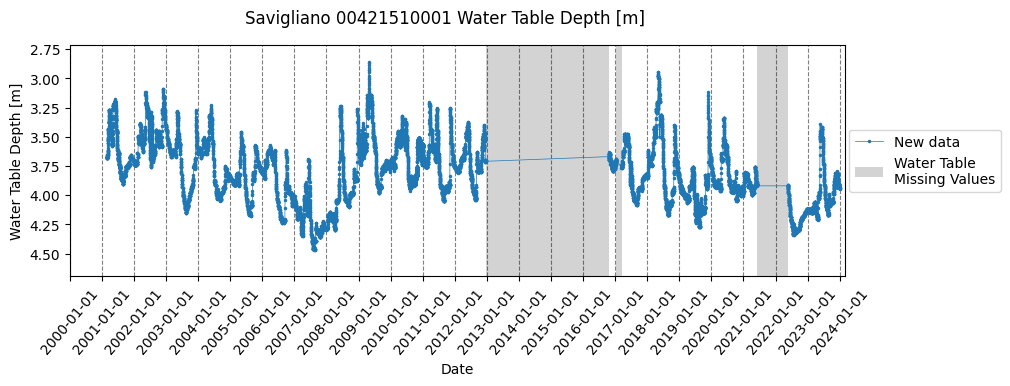

In [52]:
# Select the sensor to look at

look_at_sensor = 0
plot_ts_with_gaps(date = water_table_depth_ts_GM_dictionary_subset[id_code_senors_GM[look_at_sensor]]["Date"].values,
                  y = water_table_depth_ts_GM_dictionary_subset[id_code_senors_GM[look_at_sensor]]["Value"].values,
                  title = sensor_titles[look_at_sensor],
                  width = 10,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.21,
                  saving_path = None, label_base_series = "New data", color_base_series = "tab:blue",
                  xlimits = [np.datetime64("2000-01-01"), np.datetime64("2024-03-01")],
                  zoom = None)

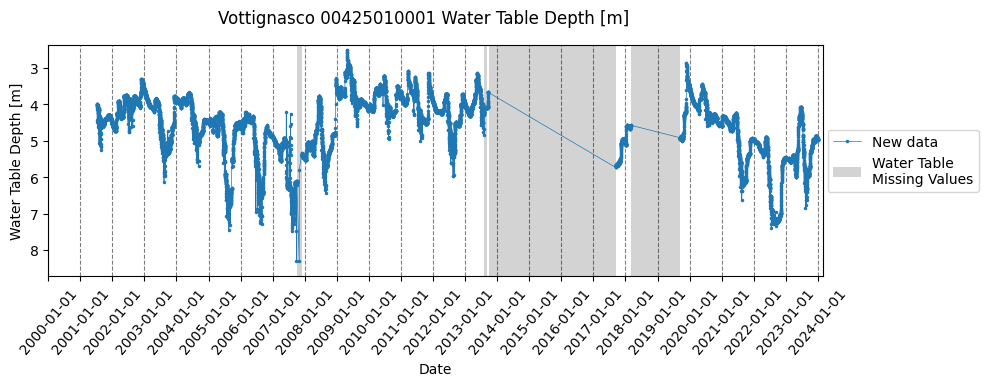

In [ ]:
# Select the sensor to look at

look_at_sensor = 1
plot_ts_with_gaps(date = water_table_depth_ts_GM_dictionary_subset[id_code_senors_GM[look_at_sensor]]["Date"].values,
                  y = water_table_depth_ts_GM_dictionary_subset[id_code_senors_GM[look_at_sensor]]["Value"].values,
                  title = sensor_titles[look_at_sensor],
                  width = 10,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.21,
                  saving_path = None, label_base_series = "New data", color_base_series = "tab:blue",
                  xlimits = [np.datetime64("2000-01-01"), np.datetime64("2024-03-01")],
                  zoom = None)

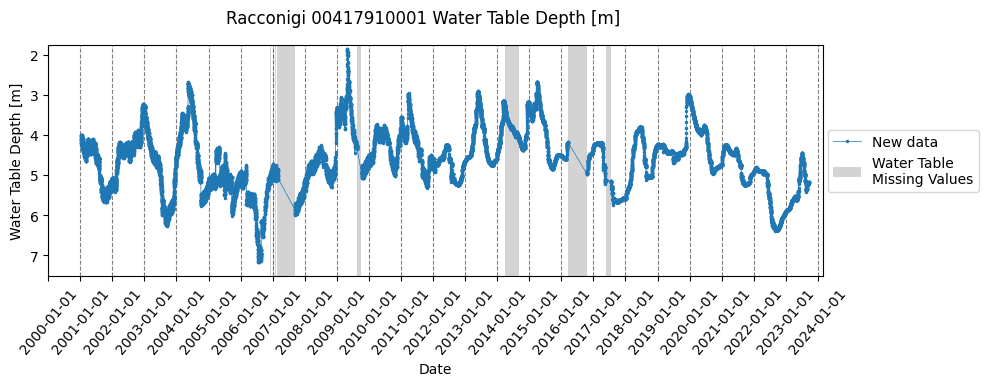

In [ ]:
# Select the sensor to look at

look_at_sensor = 2
plot_ts_with_gaps(date = water_table_depth_ts_GM_dictionary_subset[id_code_senors_GM[look_at_sensor]]["Date"].values,
                  y = water_table_depth_ts_GM_dictionary_subset[id_code_senors_GM[look_at_sensor]]["Value"].values,
                  title = sensor_titles[look_at_sensor],
                  width = 10,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.21,
                  saving_path = None, label_base_series = "New data", color_base_series = "tab:blue",
                  xlimits = [np.datetime64("2000-01-01"), np.datetime64("2024-03-01")],
                  zoom = None)

## Statistics

In [ ]:
# Build dataframe useful for yearly and monthly box-plots

water_table_depth_dictionary_monthly_statistics = copy.deepcopy(water_table_depth_ts_GM_dictionary_subset)
water_table_depth_dictionary_yearly_statistics = copy.deepcopy(water_table_depth_ts_GM_dictionary_subset)
water_table_depth_dictionary_yearly_means = copy.deepcopy(water_table_depth_ts_GM_dictionary_subset)

In [ ]:
# Build objects useful for yearly and monthly box-plots

for sensor in range(len(id_code_senors_GM)):

  # Add a column with the number of month
  water_table_depth_dictionary_monthly_statistics[id_code_senors_GM[sensor]]["month"] = water_table_depth_dictionary_monthly_statistics[id_code_senors_GM[sensor]].Date.dt.month

  # Add a column with the year
  water_table_depth_dictionary_yearly_statistics[id_code_senors_GM[sensor]]["year"] = water_table_depth_dictionary_yearly_statistics[id_code_senors_GM[sensor]].Date.dt.year
  # Compute yearly average
  water_table_depth_dictionary_yearly_means[id_code_senors_GM[sensor]] = water_table_depth_dictionary_yearly_statistics[id_code_senors_GM[sensor]].groupby("year").mean(numeric_only = True)
  water_table_depth_dictionary_yearly_means[id_code_senors_GM[sensor]]["year"] = water_table_depth_dictionary_yearly_means[id_code_senors_GM[sensor]].index

  # If some year is totally missing, add a NA for that year
  # For yearly statistic dataframe
  if (np.any(~np.in1d(np.arange(2001,2024,1),water_table_depth_dictionary_yearly_statistics[id_code_senors_GM[sensor]]["year"].unique()))):
      missing_years = np.arange(2001,2024,1)[~np.in1d(np.arange(2001,2024,1),water_table_depth_dictionary_yearly_statistics[id_code_senors_GM[sensor]]["year"].unique())]
      new_rows = {'Value': list(np.full(shape=missing_years.shape[0], fill_value=np.nan)), 'year': list(missing_years)}
      water_table_depth_dictionary_yearly_statistics[id_code_senors_GM[sensor]] = pd.concat([water_table_depth_dictionary_yearly_statistics[id_code_senors_GM[sensor]], pd.DataFrame(new_rows)], ignore_index = True)
      water_table_depth_dictionary_yearly_statistics[id_code_senors_GM[sensor]].sort_values(by='year', inplace = True)

  # For the yearly means dataframe
  if (np.any(~np.in1d(np.arange(2001,2024,1),water_table_depth_dictionary_yearly_means[id_code_senors_GM[sensor]]["year"].values))):
      missing_years = np.arange(2001,2024,1)[~np.in1d(np.arange(2001,2024,1),water_table_depth_dictionary_yearly_means[id_code_senors_GM[sensor]]["year"].values)]
      new_rows = {'Value': list(np.full(shape=missing_years.shape[0], fill_value=np.nan)), 'year': list(missing_years)}
      water_table_depth_dictionary_yearly_means[id_code_senors_GM[sensor]] = pd.concat([water_table_depth_dictionary_yearly_means[id_code_senors_GM[sensor]], pd.DataFrame(new_rows)], ignore_index = True)
      water_table_depth_dictionary_yearly_means[id_code_senors_GM[sensor]].sort_values(by='year', inplace = True)


<ipython-input-135-be6a82af8095>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[sensor, 1].set_xticklabels(ax[sensor, 1].get_xticklabels(),rotation=45)
<ipython-input-135-be6a82af8095>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[sensor, 1].set_xticklabels(ax[sensor, 1].get_xticklabels(),rotation=45)
<ipython-input-135-be6a82af8095>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[sensor, 1].set_xticklabels(ax[sensor, 1].get_xticklabels(),rotation=45)


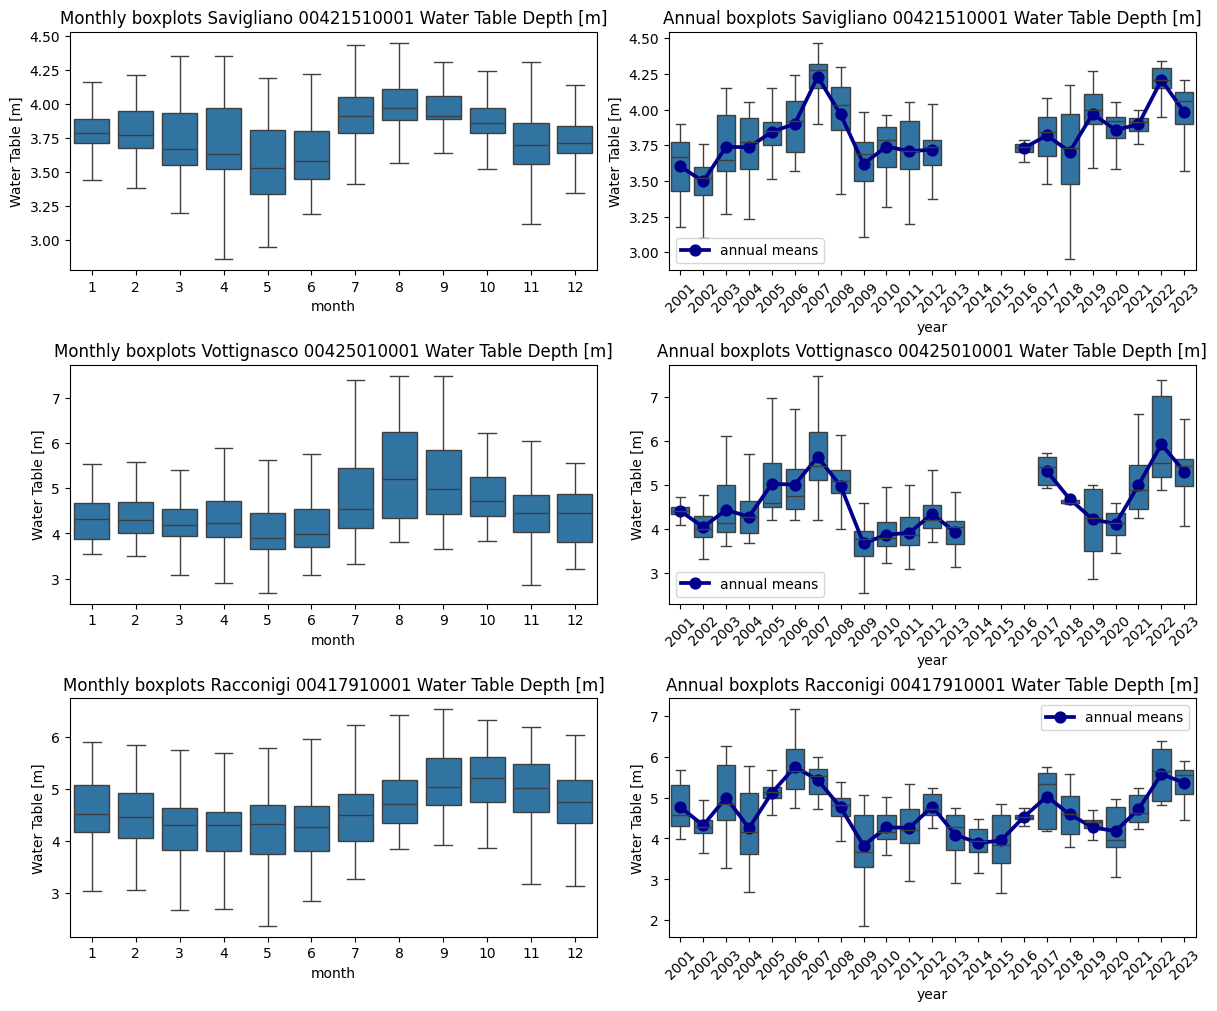

In [ ]:
# Display monthly and yearly box-plots (IT WILL TAKE A COUPLE OF MINUTES)

fig, ax = plt.subplots(len(id_code_senors_GM),2, constrained_layout = True, figsize = (12,10))

for sensor in range(len(id_code_senors_GM)):
#fig.set_size_inches((12,4))


  sns.boxplot(x='month',y='Value',data=water_table_depth_dictionary_monthly_statistics[id_code_senors_GM[sensor]],
              ax=ax[sensor,0], showfliers=False, color = 'tab:blue')
  ax[sensor,0].set(ylabel = "Water Table [m]")
  ax[sensor,0].set_title("Monthly boxplots " + sensor_titles[sensor])

  sns.boxplot(x='year',y='Value',data=water_table_depth_dictionary_yearly_statistics[id_code_senors_GM[sensor]],
              ax=ax[sensor, 1], showfliers=False, color = 'tab:blue')
  sns.pointplot(x='year', y='Value', data=water_table_depth_dictionary_yearly_means[id_code_senors_GM[sensor]],
                ax=ax[sensor, 1], label="annual means", color = "darkblue")
  ax[sensor, 1].set(ylabel = "Water Table [m]")
  ax[sensor, 1].set_xticklabels(ax[sensor, 1].get_xticklabels(),rotation=45)
  ax[sensor, 1].set_title("Annual boxplots " + sensor_titles[sensor])
  ax[sensor, 1].legend()



#plt.savefig(result_eda_GM_V_catchments + "Grana_Maira_tot_prec_m_y_box_plots_ARPA.png", dpi=400, bbox_inches = 'tight')
plt.show()

In [ ]:
# Define a merged dataframe for plotting violin plot
merged_df = pd.concat([water_table_depth_ts_GM_dictionary_subset[id_code_senors_GM[sensor]] for sensor in range(len(id_code_senors_GM))],
                      ignore_index = True)

In [ ]:
merged_df

ID_code                Date  Value
0      00421510001 2001-02-23 00:00:00   3.68
1      00421510001 2001-02-23 18:00:00   3.67
2      00421510001 2001-02-24 00:00:00   3.68
3      00421510001 2001-02-24 06:00:00   3.67
4      00421510001 2001-02-24 12:00:00   3.68
...            ...                 ...    ...
70790  00417910001 2023-09-18 00:00:00   5.18
70791  00417910001 2023-09-18 08:00:00   5.18
70792  00417910001 2023-09-18 16:00:00   5.18
70793  00417910001 2023-09-19 00:00:00   5.18
70794  00417910001 2023-09-19 08:00:00   5.18

[70795 rows x 3 columns]

In [ ]:
sensor_time_series_file_names

['Savigliano-00421510001.csv',
 'Vottignasco-00425010001.csv',
 'Racconigi-00417910001.csv']

In [ ]:
ticks_labels_violin_water_table = [sensor_time_series_file_names[i].replace("-", "\n") for i in range(len(sensor_time_series_file_names))]
ticks_labels_violin_water_table = [ticks_labels_violin_water_table[i].replace(".csv", "") for i in range(len(ticks_labels_violin_water_table))]
ticks_labels_violin_water_table

['Savigliano\n00421510001',
 'Vottignasco\n00425010001',
 'Racconigi\n00417910001']

<ipython-input-140-69c305fa6073>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  legend = False).set_yticklabels(ticks_labels_violin_water_table) #, width=1.5


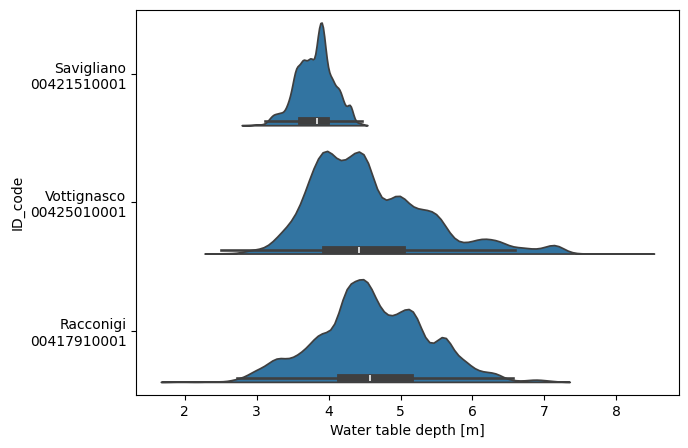

In [ ]:
plt.figure(figsize = (7,5))
sns.violinplot( y = "ID_code" , x = "Value" , data = merged_df, density_norm = "width",
               width=0.8, split=True, common_norm = True, orient = "h",
                legend = False).set_yticklabels(ticks_labels_violin_water_table) #, width=1.5
# leg = plt.gca().legend()
# leg.remove()
plt.xlabel("Water table depth [m]")
#plt.show()
#plt.savefig(result_eda_GM_V_catchments + "Grana_Maira_depth_violins.png", dpi=400, bbox_inches = 'tight')
plt.show()

## Saving dataset

In [ ]:
sensor_time_series_saving_name = [sensor_time_series_file_names[i].replace("-", "_") for i in range(len(sensor_time_series_file_names))]
sensor_time_series_saving_name = [sensor_time_series_saving_name[i].replace(".csv", "") for i in range(len(sensor_time_series_saving_name))]
sensor_time_series_saving_name = [sensor_time_series_saving_name[i]+"_Water_Table_Depth_Grana_Maira.csv" for i in range(len(sensor_time_series_saving_name))]
sensor_time_series_saving_name

['Savigliano_00421510001_Water_Table_Depth_Grana_Maira.csv',
 'Vottignasco_00425010001_Water_Table_Depth_Grana_Maira.csv',
 'Racconigi_00417910001_Water_Table_Depth_Grana_Maira.csv']

In [ ]:
for sensor in range(len(water_table_depth_ts_GM_dictionary_subset.keys())):
  name = water_table_time_series_path + sensor_time_series_saving_name[sensor]
  print("saving ", id_code_senors_GM[sensor])
  water_table_depth_ts_GM_dictionary_subset[id_code_senors_GM[sensor]].to_csv(name, index = False)

saving  00421510001
saving  00425010001
saving  00417910001
